## TCDS17 Final project - Predict & Trade the next day ILS IRS10Y

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import xgboost as xgb
from sklearn.svm import SVR
import graphviz
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
# from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [181]:
from src.make_datasets import create_dataset, ts_train_test_split
from src.make_LSTM_model import fit_LSTM_type1, fit_LSTM_type2, fit_LSTM_type3, evaluate_model
from src.visualization import mlp_learnig_curve_plot,test_predicted_plot,trade_simulation_plot,residuals_dist_plot,correlation_matrix_plot,residuals_QQ_plot
from src.trade_simulation import trade_on_pred

### Interest Rate Swap (IRS) explaind

<b>What is Interest Rate Swap</b>
* Bilateral agreement between two parties to exchange periodic interest payments over a period of time.
* Interest payments, which are calculated based on nominal principal amount, are nettled.
* Principal is not exchanged.
* One party will pay a predetermined fixed interest rate and the other party will pay a re-settable (‘floating’) interest rate
* Usually indexed on LIBOR (London Interbank Offer Rate) but can also be SOFR, EURIBOR, TELBOR etc.
* Currency of the two sets of interest payments are the same 

![IRS_fig1](./img/IRS_Fig1.png)

<b>The parties must agree on the following:</b>
* The swap's nominal amount : This amount is generally not exchanged, but cash flows (payments) are calculated against it.
* The swap’s maturity: number of years the agreement is binding.
* The relevant interest rate index: While the fixed coupon is set at the beginning, the floating payment is tied to some agreed-upon index. Often this is 3 or 6-month LIBOR but many other possibilities exist (TELBOR).
* Payment (or “re-set”) dates: How Frequency of exchange of the payments 

<b>Calculation of Swap Rate</b>
* Interest rate swaps are priced so that on the trade date, both sides of the transaction have equivalent NPVs.
* The fixed rate payer is expected to pay the same amount as the floating rate payer over the life of the swap, given the prevailing rate environment (where today’s forward curve lies).
* On the trade date, swaps can be thought as an exchange of a fixed rate bond, for a floating rate bond. #### Interest Rate Swaps explained

for example :<br>
Buyer of ILS IRS10Y (AM / 3T) : <br>
* <b>Pay Fix</b>       : Annual fixed rate (IRS rate) for each year and for 10 years <br>
* <b>Receive Float</b> : Quarterly float rate (TELBOR 3M) for 10 years

### Data exploration

Two datasets :
* ILS IRS (AM / 3T) - historical data for closing bid price for all tenors of the ILS swap curve (1Y-30Y)
* USD IRS (AM / 3L) - historical data for closing bid price for all tenors of the USD swap curve (1Y-50Y)

load the ILSIRS dataset and parse the date column to time series

In [5]:
df_ILSIRS_curve = pd.read_csv('./data/ILSIRS_AM3T_data.csv',parse_dates=['Date'])

check the DataFrame cols names and search for NA and for duplicates dates - not found any

In [6]:
cols=df_ILSIRS_curve.columns
cols

Index(['Date', 'ILS1Y', 'ILS2Y', 'ILS3Y', 'ILS4Y', 'ILS5Y', 'ILS6Y', 'ILS7Y',
       'ILS8Y', 'ILS9Y', 'ILS10Y', 'ILS12Y', 'ILS15Y', 'ILS20Y', 'ILS25Y',
       'ILS30Y'],
      dtype='object')

In [7]:
df_ILSIRS_curve['Date'].duplicated().sum()

0

* Drop the 25Y and 30Y cols because of lack of enough market liquidity at the back end of the swap curve <br>
Slice the last 10 years from the dataset

In [8]:
cols_to_drop=['ILS25Y','ILS30Y']
cols = [col for col in cols if col not in cols_to_drop]

In [9]:
ts_ILS=df_ILSIRS_curve[cols].set_index('Date').sort_index(ascending=True)
start_date ,end_date = '2011-12-19','2022-05-11'
ts_ILS=ts_ILS[start_date:end_date]

In [10]:
ts_ILS.isna().sum()

ILS1Y     0
ILS2Y     0
ILS3Y     0
ILS4Y     0
ILS5Y     0
ILS6Y     0
ILS7Y     0
ILS8Y     0
ILS9Y     0
ILS10Y    0
ILS12Y    0
ILS15Y    0
ILS20Y    0
dtype: int64

* Calc and plot correlations heatmap between the dataset features

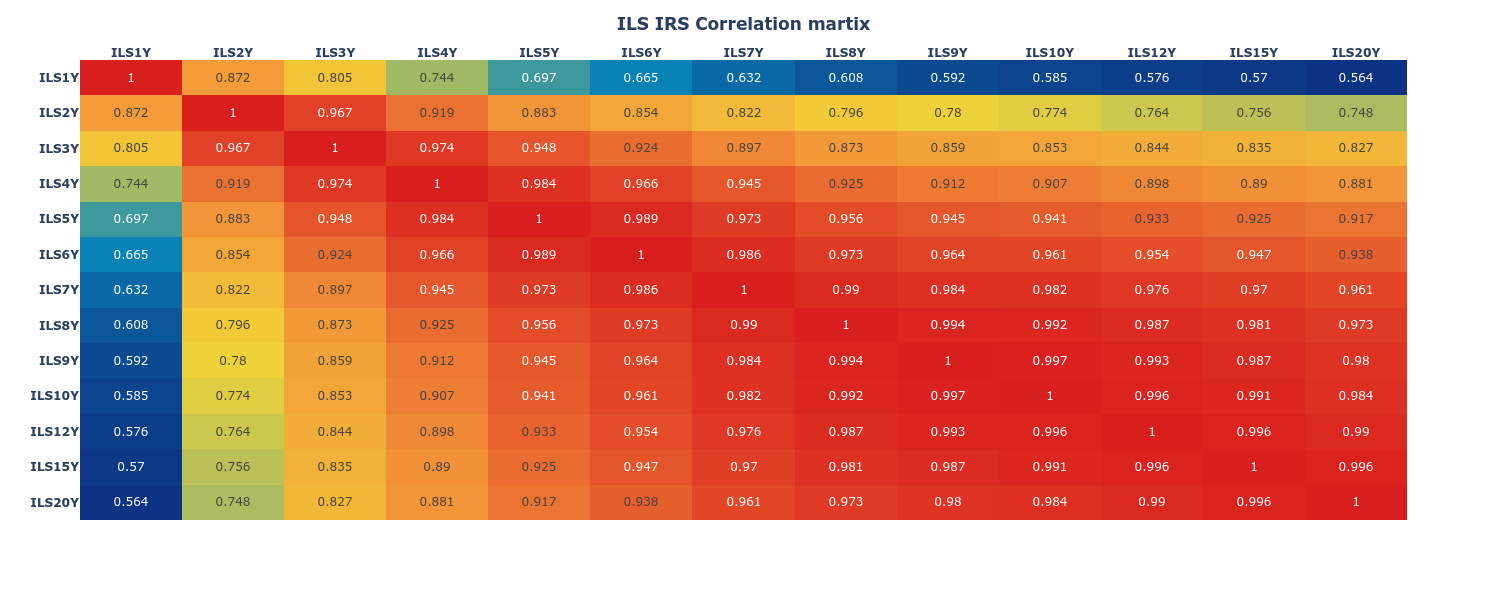

In [11]:
correlation_matrix_plot(ts_ILS.diff(axis=0).corr(),"<b>ILS IRS Correlation martix</b>").show()

* High correlation between the features

In [12]:
target='ILS10Y'
ts1=ts_ILS[target].to_frame()
ts1

ILS10Y
Date              
2011-12-19   4.230
2011-12-20   4.240
2011-12-21   4.240
2011-12-22   4.210
2011-12-23   4.210
...            ...
2022-05-04   2.445
2022-05-06   2.530
2022-05-09   2.665
2022-05-10   2.695
2022-05-11   2.725

[2528 rows x 1 columns]

In [13]:
ts1.isnull().sum()

ILS10Y    0
dtype: int64

### Simple baselines prediction & Analysis

* Start w/ calc several very simple baseline predictions on the ILS10Y time series :  
    * lag 1 day 
    * simple moving average for 2, 5 ,10 trading days.
* For each baseline prediction calc the MAE and STD of the residuals and plot distribution histogram.
* Make trading simulation on the daily predictions w/ the actual closing price.

In [14]:
n_lag=1
lag_col='lag_'+str(n_lag)
ts1[lag_col]=ts1[target].shift(n_lag)

In [15]:
n_lag=2
sma2='SMA'+str(n_lag)
ts1[sma2] = ts1[target].rolling(n_lag,closed='left').mean()

In [16]:
n_lag=5
sma5='SMA'+str(n_lag)
ts1[sma5] = ts1[target].rolling(n_lag,closed='left').mean()

In [17]:
n_lag=10
sma10='SMA'+str(n_lag)
ts1[sma10] = ts1[target].rolling(n_lag,closed='left').mean()

In [18]:
train,test = ts_train_test_split(ts1,0.9)
print(len(train), len(test))
test

2275 253


ILS10Y  lag_1    SMA2   SMA5   SMA10
Date                                            
2021-04-30   1.315  1.305  1.2925  1.247  1.2270
2021-05-03   1.290  1.315  1.3100  1.268  1.2390
2021-05-04   1.290  1.290  1.3025  1.285  1.2470
2021-05-05   1.315  1.290  1.2900  1.296  1.2550
2021-05-06   1.340  1.315  1.3025  1.303  1.2650
...            ...    ...     ...    ...     ...
2022-05-04   2.445  2.420  2.4175  2.391  2.3840
2022-05-06   2.530  2.445  2.4325  2.410  2.3915
2022-05-09   2.665  2.530  2.4875  2.441  2.4055
2022-05-10   2.695  2.665  2.5975  2.495  2.4315
2022-05-11   2.725  2.695  2.6800  2.551  2.4640

[253 rows x 5 columns]

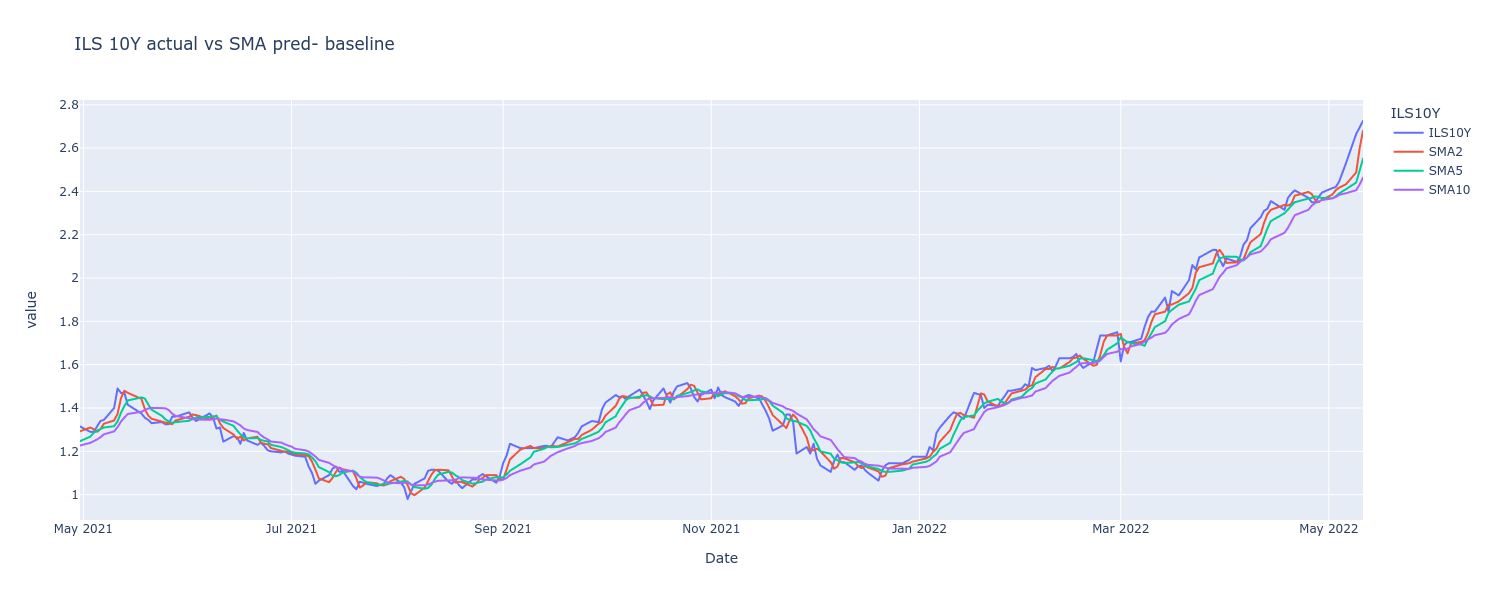

In [19]:
fig = px.line(test,x=test.index,y=[target,sma2,sma5,sma10],
              title=f'ILS 10Y actual vs SMA pred- baseline')
fig.update_layout(legend_title=target, width=800,height=600)
fig.show()

### Trading simulation explaind

* In order to be more closer to real market conditions and get more realistic trading results we have to set market bid-ask qoute spread.
* Set a threshold to halt trading if we get "above normal" range beween actual and predict price.
* Check the trading results on different thresholds.
* Trading : if actual market price and model predicted price in threshold range :
    * if actual price below predicted price - trade action is "Buy" else "Sell"
    * if trade action is "Buy" the trade price will be actual price + bid/ask spread. 
    * if trade action is "Sell" the trade price will be actual bid price. (bid side data)
* Mark-To-Markert (MTM) - 
    * Calc. the mean of the long trades and the short trades
    * Evaluate the long and the short positions against the last price on the test set

In [20]:
# bid-ask spread in bp
spread=2

In [21]:
# baseline_1 n_lag pred on prev n_lag days
lag1_mae=mean_absolute_error(test[target], test['lag_1'])
lag1_std=(test[target]-test['lag_1']).values.std()

print(f'MAE baseline - pred on lag_1 : {lag1_mae:.3f} ({lag1_std:.3f})')

MAE baseline - pred on lag_1 : 0.028 (0.036)


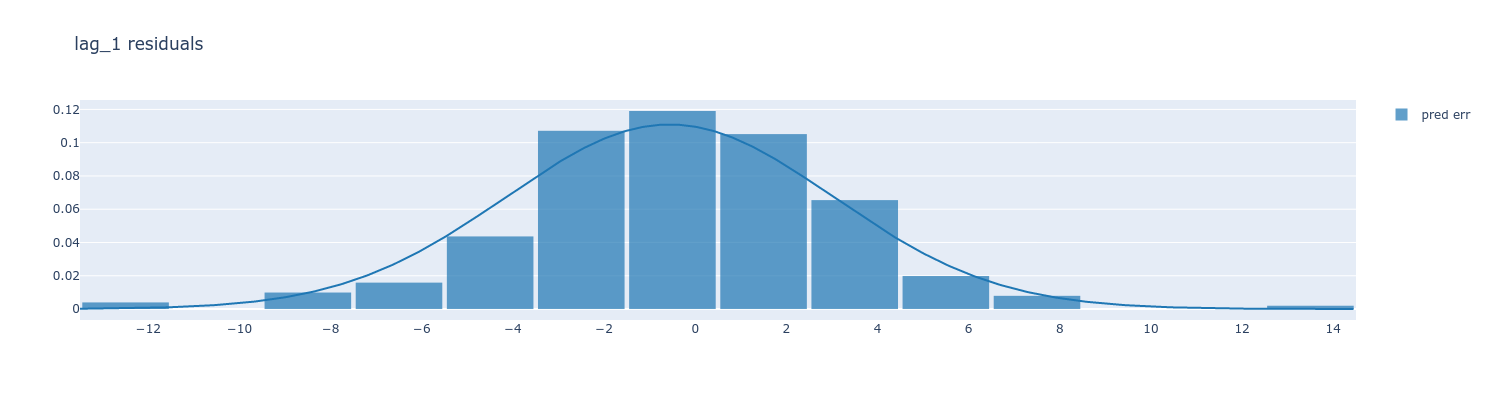

In [22]:
# residuals = pred - actual
title='lag_1 residuals'
residuals_dist_plot(test[target],test['lag_1'],'probability density','normal',title)

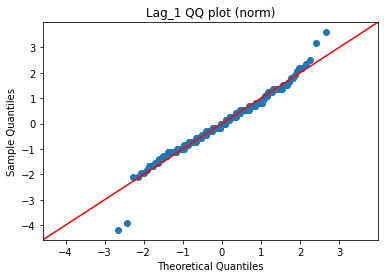

In [23]:
# QQ plot to check if residuals are normal distributed
residuals_QQ_plot(test[target],test['lag_1'],'Lag_1 QQ plot (norm)').show()

In [24]:
# lag_1 - trade treshold : MAE
trade_on_pred(test[target],test['lag_1'],spread,lag1_mae*100)

Long   Short  Total  Trades Spread
Pos    60.0   -69.0   -9.0     129      2
MTM  8197.5 -8581.0 -383.5     253

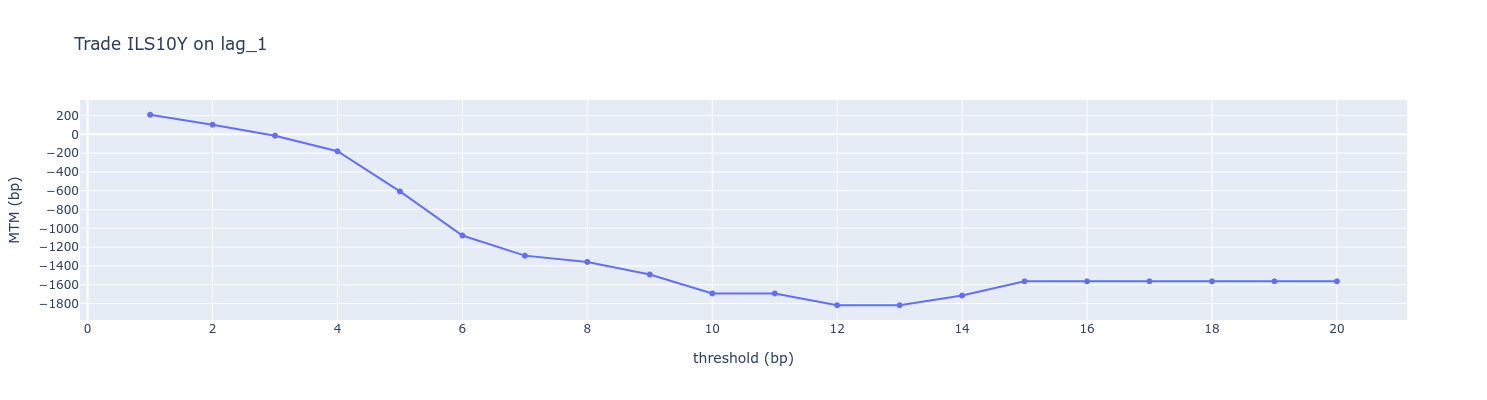

In [25]:
title=f'Trade ILS10Y on lag_1'
trade_simulation_plot(test[target],test['lag_1'],spread,title).show()

In [26]:
# baseline_2 - simple moving avarage w/ lag_2
sma2_mae=mean_absolute_error(test[target], test['SMA2'])
sma2_std=(test[target]-test['SMA2']).values.std()

print(f'MAE baseline - pred on SMA{n_lag} : {sma2_mae:.3f} ({sma2_std:.3f})')

MAE baseline - pred on SMA10 : 0.033 (0.041)


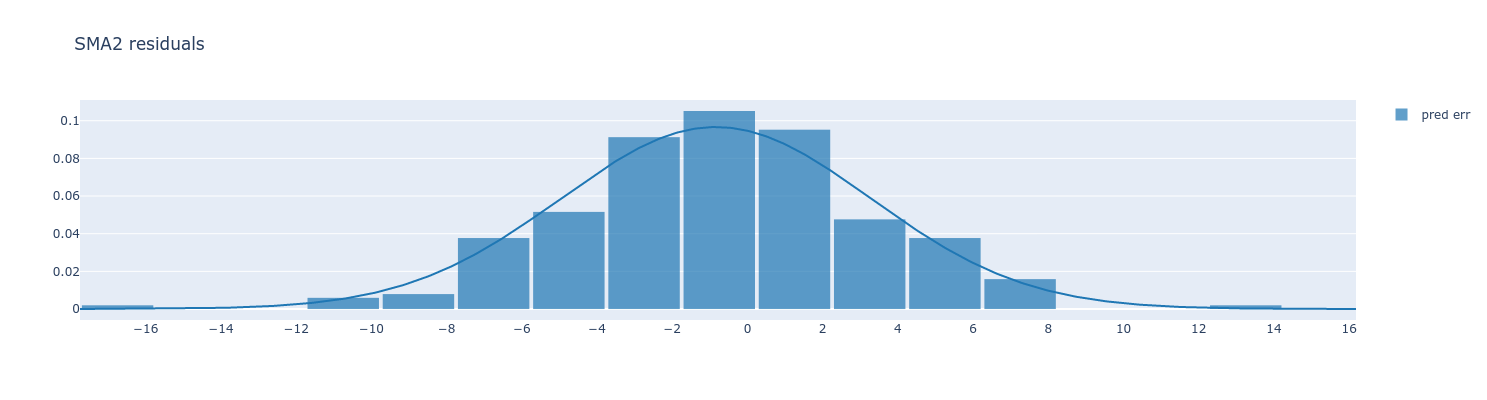

In [27]:
# residuals = pred - actual
title='SMA2 residuals'
residuals_dist_plot(test[target],test['SMA2'],'probability density','normal',title)

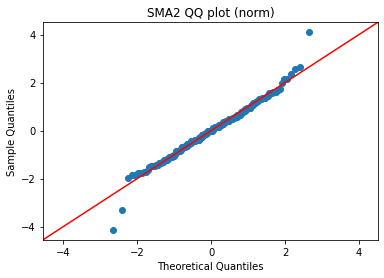

In [28]:
# QQ plot to check if residuals are normal distributed
residuals_QQ_plot(test[target],test['SMA2'],'SMA2 QQ plot (norm)').show()

In [29]:
# SMA2 - trade treshold : MAE
trade_on_pred(test[target],test[sma2],spread,sma2_mae*100)

Long    Short   Total  Trades Spread
Pos    61.0    -91.0   -30.0     152      2
MTM  8382.0 -11406.5 -3024.5     253

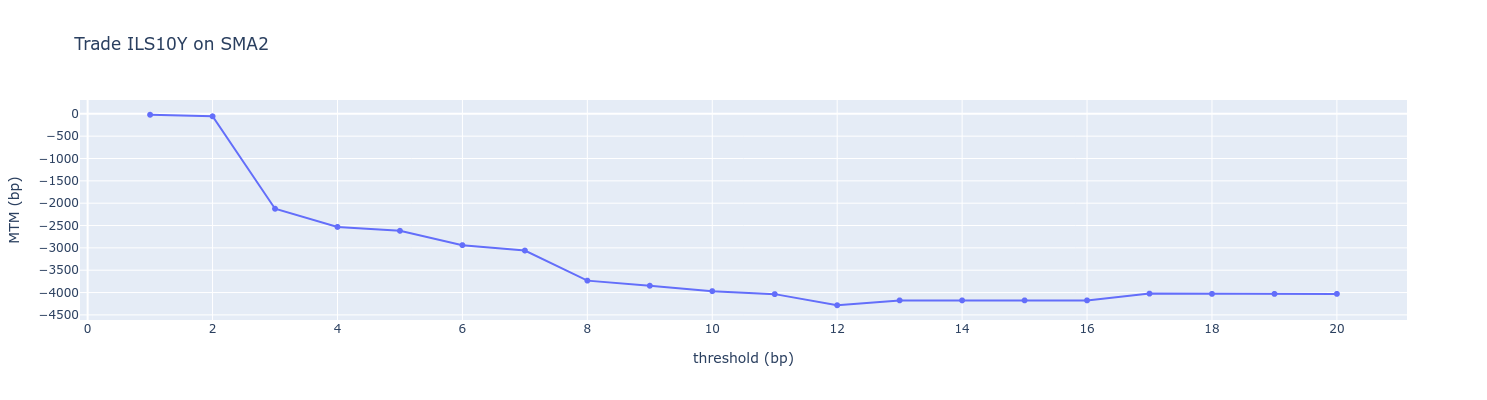

In [30]:
title=f'Trade ILS10Y on SMA2'
trade_simulation_plot(test[target],test[sma2],spread,title).show()

In [31]:
# baseline_3 - simple moving avarage w/ lag_5
sma5_mae=mean_absolute_error(test[target], test['SMA5'])
sma5_std=(test[target]-test['SMA5']).values.std()

print(f'MAE baseline for SMA{n_lag} : {sma5_mae:.3f} ({sma5_std:.3f})')

MAE baseline for SMA10 : 0.046 (0.057)


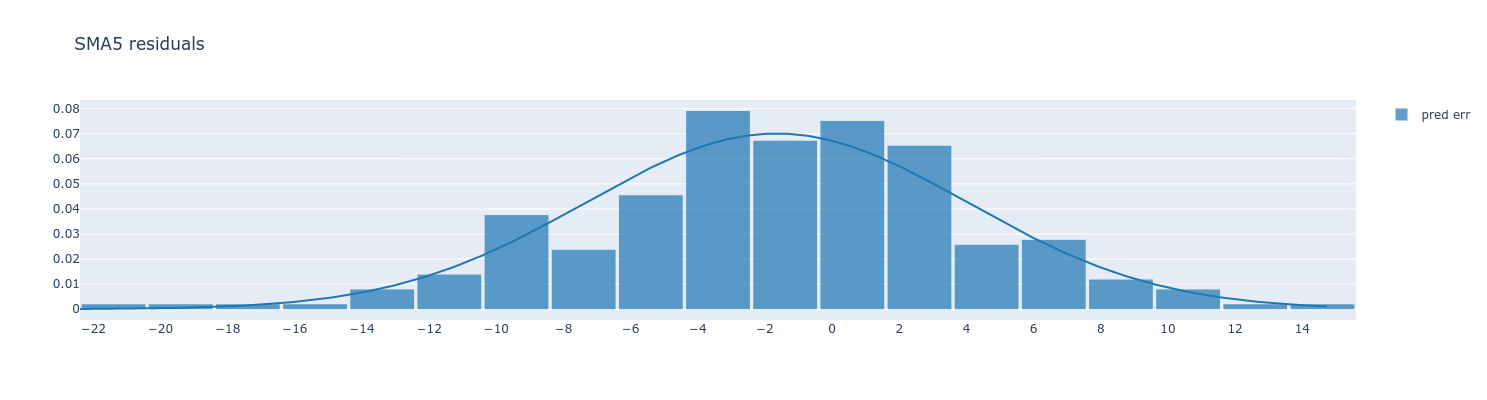

In [32]:
title='SMA5 residuals'
residuals_dist_plot(test[target],test['SMA5'],'probability density','normal',title)

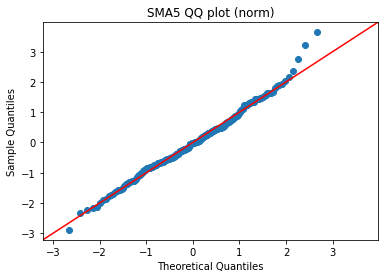

In [33]:
# QQ plot to check if residuals are normal distributed
residuals_QQ_plot(test[target],test['SMA5'],'SMA5 QQ plot (norm)').show()

In [34]:
# SMA5 - trade treshold : MAE
trade_on_pred(test[target],test[sma5],spread,sma5_mae*100)

Long    Short   Total  Trades Spread
Pos    68.0    -86.0   -18.0     154      2
MTM  9262.5 -11366.0 -2103.5     253

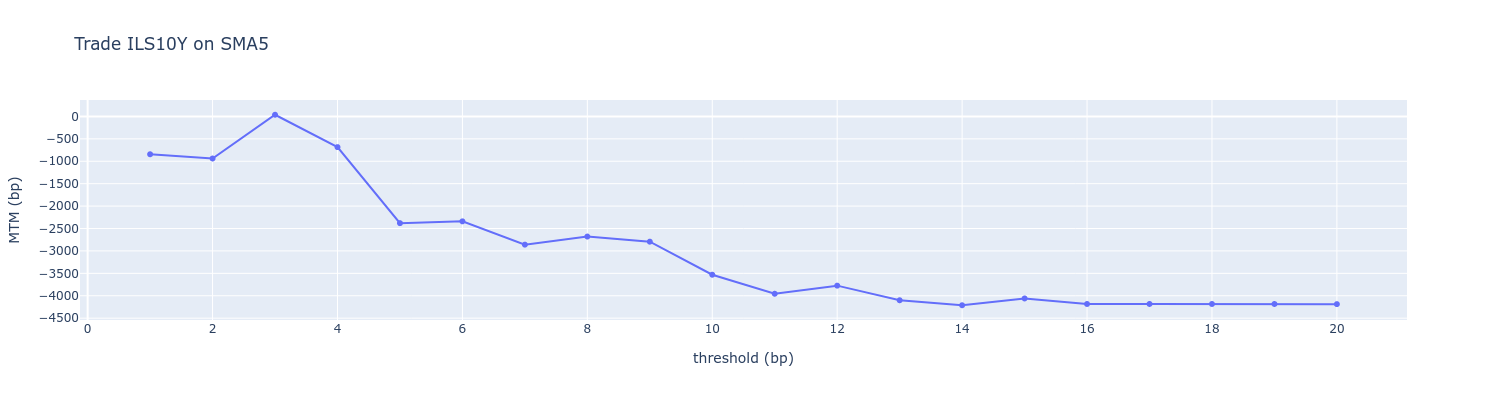

In [35]:
title=f'Trade ILS10Y on SMA5'
trade_simulation_plot(test[target],test[sma5],spread,title).show()

In [36]:
# baseline_4 - simple moving avarage w/ lag_10
sma10_mae=mean_absolute_error(test[target], test['SMA10'])
sma10_std=(test[target]-test['SMA10']).values.std()

print(f'MAE baseline for SMA{n_lag} : {sma10_mae:.3f} ({sma10_std:.3f})')

MAE baseline for SMA10 : 0.065 (0.077)


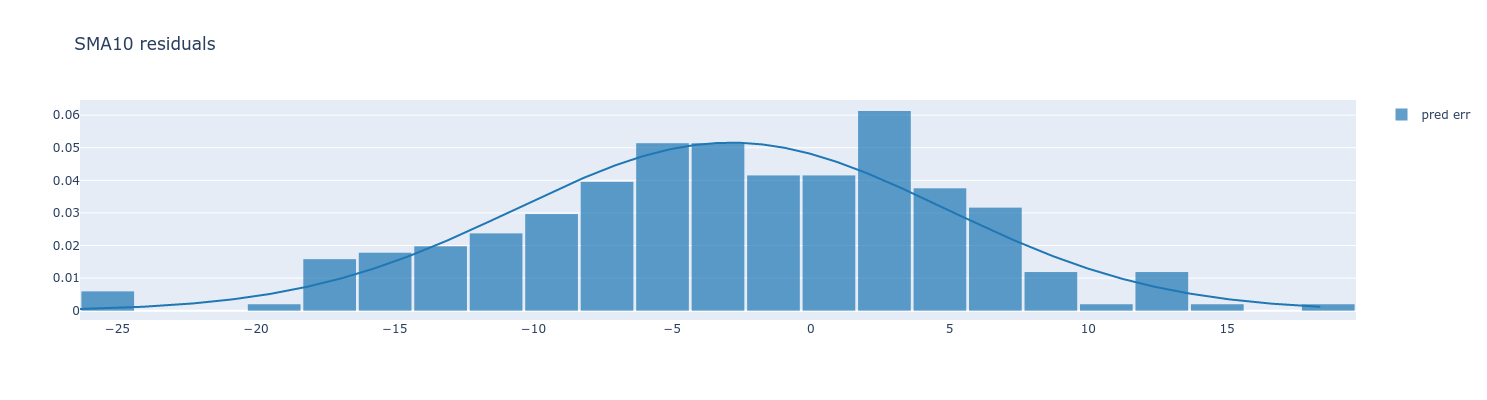

In [37]:
title='SMA10 residuals'
residuals_dist_plot(test[target],test['SMA10'],'probability density','normal',title)

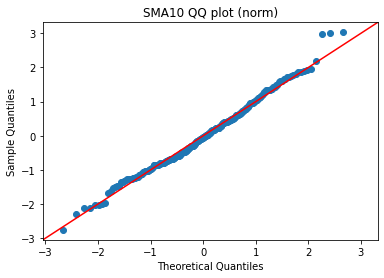

In [38]:
# QQ plot to check if residuals are normal distributed
residuals_QQ_plot(test[target],test['SMA10'],'SMA10 QQ plot (norm)').show()

In [39]:
# SMA10 - trade treshold : MAE
sma10_results=trade_on_pred(test[target],test[sma10],spread,sma10_mae*100)
sma10_results

Long   Short  Total  Trades Spread
Pos     72.0   -79.0   -7.0     151      2
MTM  10513.0 -9731.0  782.0     253

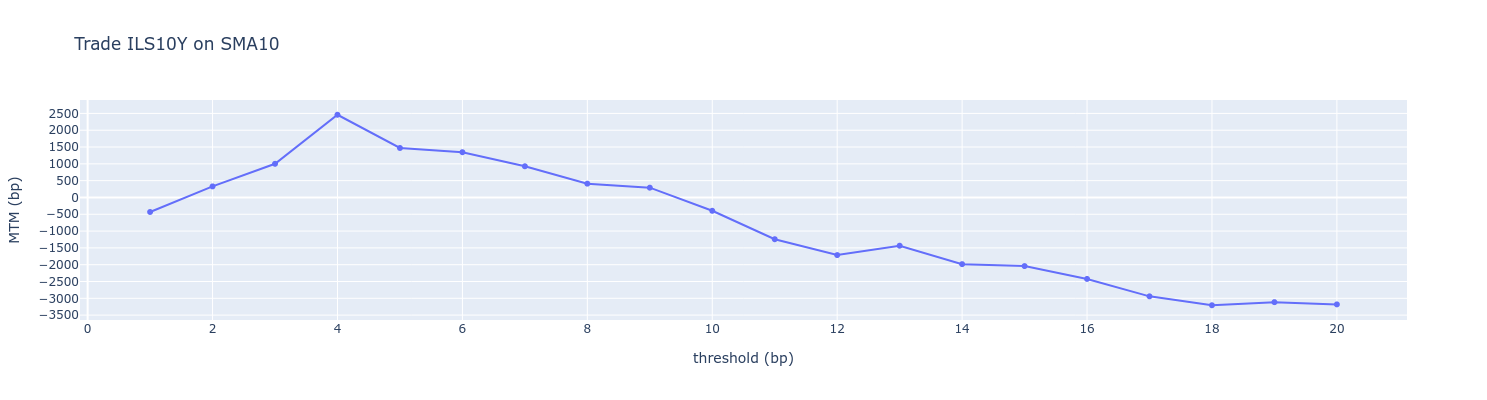

In [40]:
title=f'Trade ILS10Y on SMA10'
trade_simulation_plot(test[target],test[sma10],spread,title).show()

### Simple baselines trade simulation summary 
* All the simple baseline trading strategies lose money w/o a threshold.
* Trading on lag_1 and SMA10 w/ tight threshold make a profit but its seems unrealistic in real world conditions.


### XGboost and SVR

* Adding more complex predict models to the baseline analysis : XGboost and SVR
* The next day prediction will base on learing from the 10 lags business days
* Lags as features to predict the target - prepare a 1d to 10d lag dataset from the ILS10Y time series
* train / test data split - train on 9 years (last 2y-10y history) and predict the last year (1y histoey)

In [41]:
ts2=ts_ILS[target].to_frame()
ts2

ILS10Y
Date              
2011-12-19   4.230
2011-12-20   4.240
2011-12-21   4.240
2011-12-22   4.210
2011-12-23   4.210
...            ...
2022-05-04   2.445
2022-05-06   2.530
2022-05-09   2.665
2022-05-10   2.695
2022-05-11   2.725

[2528 rows x 1 columns]

In [42]:
train,test = ts_train_test_split(ts2,0.9)
print(len(train), len(test))

2275 253


In [43]:
n_lag = 10
n_features = 1

In [44]:
# reshape to [samples, n_steps, n_features]
X_train, y_train = create_dataset(train, train[target], n_lag)
X_test, y_test = create_dataset(test, test[target], n_lag)

print(f'X_train shape:{X_train.shape}  y_train shape:{y_train.shape}')
print(f'X_test  shape:{X_test.shape}   y_test  shape:{y_test.shape}')

X_train shape:(2265, 10, 1)  y_train shape:(2265,)
X_test  shape:(243, 10, 1)   y_test  shape:(243,)


In [45]:
# make lag dataset
cols=['lag_'+str(n_lag+1-lag) for lag in range(1,n_lag+1)]
ts_train=pd.DataFrame(X_train.reshape(X_train.shape[0],X_train.shape[1]),columns=cols)
ts_train[target]=y_train
ts_train=ts_train.set_index(train.index[n_lag:])
ts_train

lag_10  lag_9  lag_8  lag_7  lag_6  lag_5  lag_4  lag_3  lag_2  \
Date                                                                         
2012-01-03   4.230  4.240  4.240  4.210  4.210  4.210  4.260  4.240  4.210   
2012-01-04   4.240  4.240  4.210  4.210  4.210  4.260  4.240  4.210  4.210   
2012-01-05   4.240  4.210  4.210  4.210  4.260  4.240  4.210  4.210  4.130   
2012-01-06   4.210  4.210  4.210  4.260  4.240  4.210  4.210  4.130  4.110   
2012-01-09   4.210  4.210  4.260  4.240  4.210  4.210  4.130  4.110  4.130   
...            ...    ...    ...    ...    ...    ...    ...    ...    ...   
2021-04-23   1.220  1.235  1.235  1.245  1.225  1.195  1.210  1.210  1.215   
2021-04-26   1.235  1.235  1.245  1.225  1.195  1.210  1.210  1.215  1.205   
2021-04-27   1.235  1.245  1.225  1.195  1.210  1.210  1.215  1.205  1.210   
2021-04-28   1.245  1.225  1.195  1.210  1.210  1.215  1.205  1.210  1.205   
2021-04-29   1.225  1.195  1.210  1.210  1.215  1.205  1.210  1.205  1.235   

            lag_1  ILS10Y  
Date                       
2012-01-03  4.210   4.130  
2012-01-04  4.130   4.110  
2012-01-05  4.110   4.130  
2012-01-06  4.130   4.130  
2012-01-09  4.130   4.120  
...           ...     ...  
2021-04-23  1.205   1.210  
2021-04-26  1.210   1.205  
2021-04-27  1.205   1.235  
2021-04-28  1.235   1.280  
2021-04-29  1.280   1.305  

[2265 rows x 11 columns]

In [46]:
ts_test=pd.DataFrame(X_test.reshape(X_test.shape[0],X_test.shape[1]),columns=cols)
ts_test[target]=y_test
ts_test=ts_test.set_index(test.index[n_lag:])
ts_test

lag_10  lag_9  lag_8  lag_7  lag_6  lag_5  lag_4  lag_3  lag_2  \
Date                                                                         
2021-05-14   1.315  1.290  1.290  1.315  1.340  1.345  1.400  1.490  1.470   
2021-05-18   1.290  1.290  1.315  1.340  1.345  1.400  1.490  1.470  1.470   
2021-05-19   1.290  1.315  1.340  1.345  1.400  1.490  1.470  1.470  1.415   
2021-05-20   1.315  1.340  1.345  1.400  1.490  1.470  1.470  1.415  1.375   
2021-05-21   1.340  1.345  1.400  1.490  1.470  1.470  1.415  1.375  1.355   
...            ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-05-04   2.370  2.390  2.405  2.370  2.350  2.350  2.375  2.395  2.415   
2022-05-06   2.390  2.405  2.370  2.350  2.350  2.375  2.395  2.415  2.420   
2022-05-09   2.405  2.370  2.350  2.350  2.375  2.395  2.415  2.420  2.445   
2022-05-10   2.370  2.350  2.350  2.375  2.395  2.415  2.420  2.445  2.530   
2022-05-11   2.350  2.350  2.375  2.395  2.415  2.420  2.445  2.530  2.665   

            lag_1  ILS10Y  
Date                       
2021-05-14  1.470   1.415  
2021-05-18  1.415   1.375  
2021-05-19  1.375   1.355  
2021-05-20  1.355   1.345  
2021-05-21  1.345   1.330  
...           ...     ...  
2022-05-04  2.420   2.445  
2022-05-06  2.445   2.530  
2022-05-09  2.530   2.665  
2022-05-10  2.665   2.695  
2022-05-11  2.695   2.725  

[243 rows x 11 columns]

In [47]:
X_ts_train=ts_train.iloc[:,:-1]
y_ts_train=ts_train.iloc[:,-1]

X_ts_test=ts_test.iloc[:,:-1]
y_ts_test=ts_test.iloc[:,-1]

In [48]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror",early_stopping_rounds=5, eval_metric=["rmse","mae"])
xgb_model.fit(X_ts_train, y_ts_train, eval_set=[(X_ts_test, y_ts_test)])

[0]	validation_0-rmse:0.72881	validation_0-mae:0.66930
[1]	validation_0-rmse:0.51713	validation_0-mae:0.47281
[2]	validation_0-rmse:0.36686	validation_0-mae:0.33192
[3]	validation_0-rmse:0.26296	validation_0-mae:0.23494
[4]	validation_0-rmse:0.19201	validation_0-mae:0.16892
[5]	validation_0-rmse:0.14234	validation_0-mae:0.12257
[6]	validation_0-rmse:0.10829	validation_0-mae:0.09060
[7]	validation_0-rmse:0.08644	validation_0-mae:0.07061
[8]	validation_0-rmse:0.07125	validation_0-mae:0.05745
[9]	validation_0-rmse:0.06217	validation_0-mae:0.05015
[10]	validation_0-rmse:0.05699	validation_0-mae:0.04592
[11]	validation_0-rmse:0.05391	validation_0-mae:0.04333
[12]	validation_0-rmse:0.05261	validation_0-mae:0.04232
[13]	validation_0-rmse:0.05159	validation_0-mae:0.04142
[14]	validation_0-rmse:0.05090	validation_0-mae:0.04081
[15]	validation_0-rmse:0.05059	validation_0-mae:0.04054
[16]	validation_0-rmse:0.05009	validation_0-mae:0.04015
[17]	validation_0-rmse:0.04988	validation_0-mae:0.04000
[1

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=5, enable_categorical=False,
             eval_metric=['rmse', 'mae'], gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [49]:
y_ts_train_pred = xgb_model.predict(X_ts_train)
y_ts_test_pred  = xgb_model.predict(X_ts_test)

train_mae = mean_absolute_error(y_ts_train, y_ts_train_pred)
test_mae  = mean_absolute_error(y_ts_test, y_ts_test_pred)

train_err_std = (y_ts_train - y_ts_train_pred).std()
test_err_std  = (y_ts_test  -  y_ts_test_pred).std()

print(f'Train MAE: {train_mae:.3f} ({train_err_std:.3f}), Test MAE: {test_mae:.3f} ({test_err_std:.3f})')

Train MAE: 0.019 (0.026), Test MAE: 0.040 (0.049)


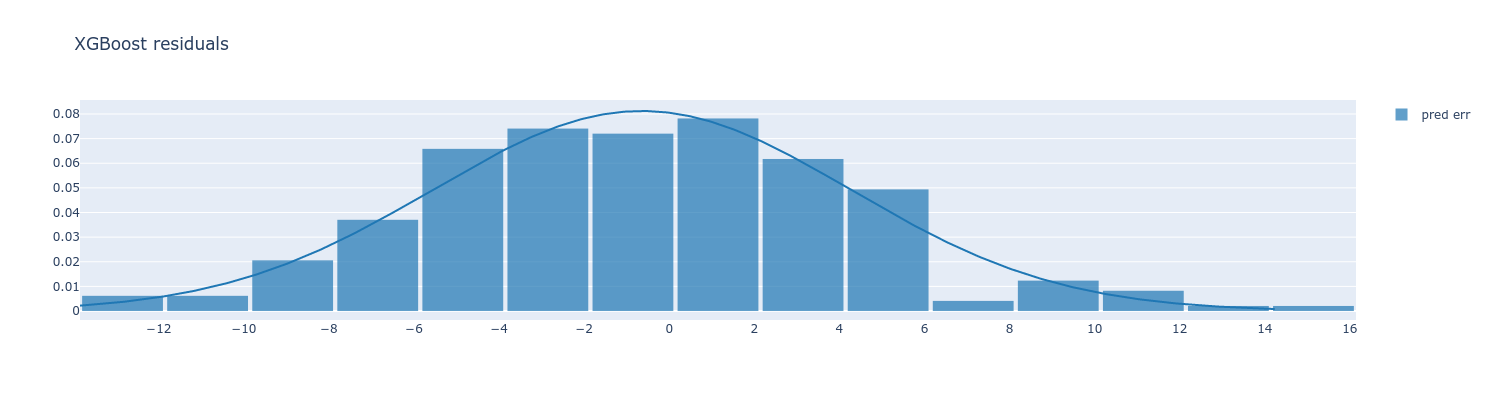

In [50]:
title='XGBoost residuals'
residuals_dist_plot(y_ts_test,y_ts_test_pred,'probability density','normal',title)

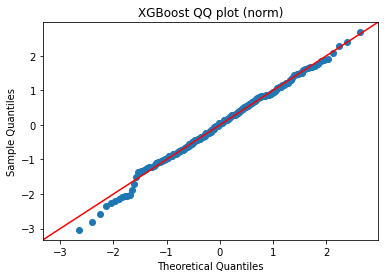

In [51]:
# QQ plot to check if residuals are normal distributed
residuals_QQ_plot(y_ts_test,y_ts_test_pred,'XGBoost QQ plot (norm)').show()

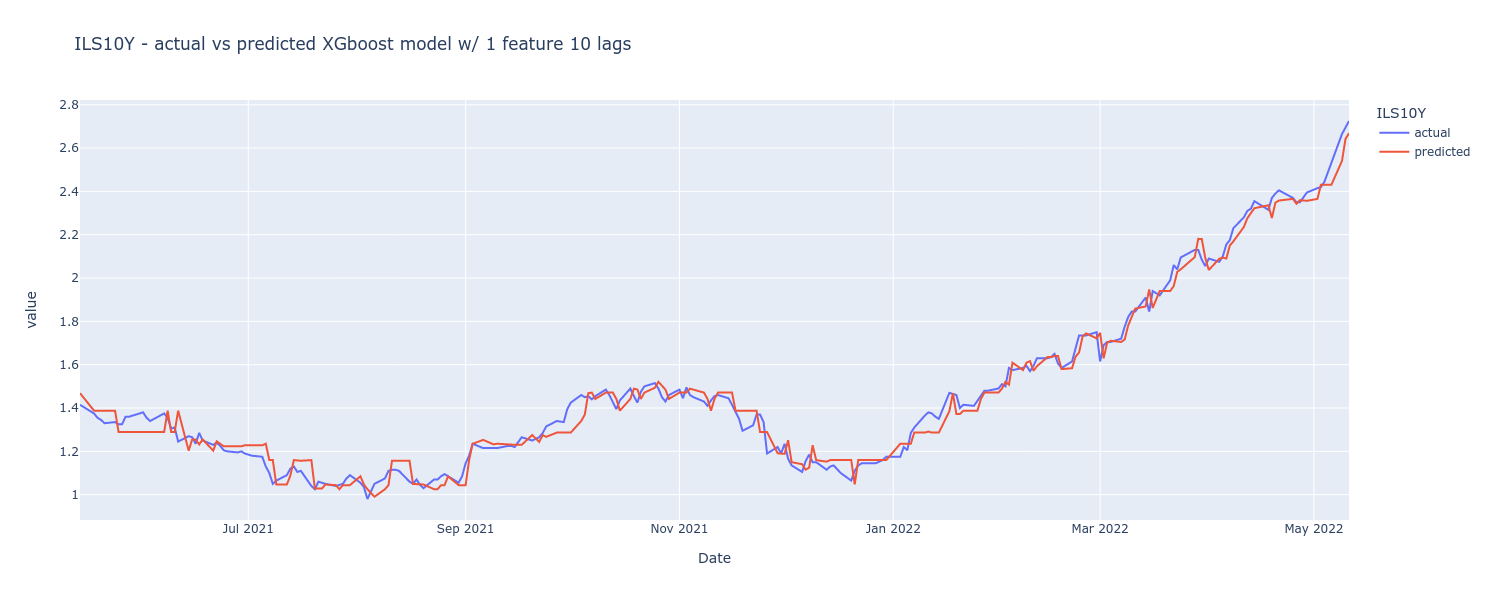

In [52]:
# test set - actual vs predicted plot
title=f'{target} - actual vs predicted XGboost model w/ {n_features} feature {n_lag} lags'
test_predicted_plot(y_ts_test.values, y_ts_test_pred, y_ts_test.index, title,target).show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

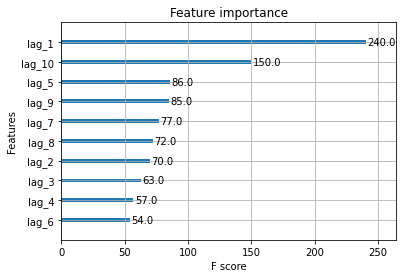

In [53]:
xgb.plot_importance(xgb_model)

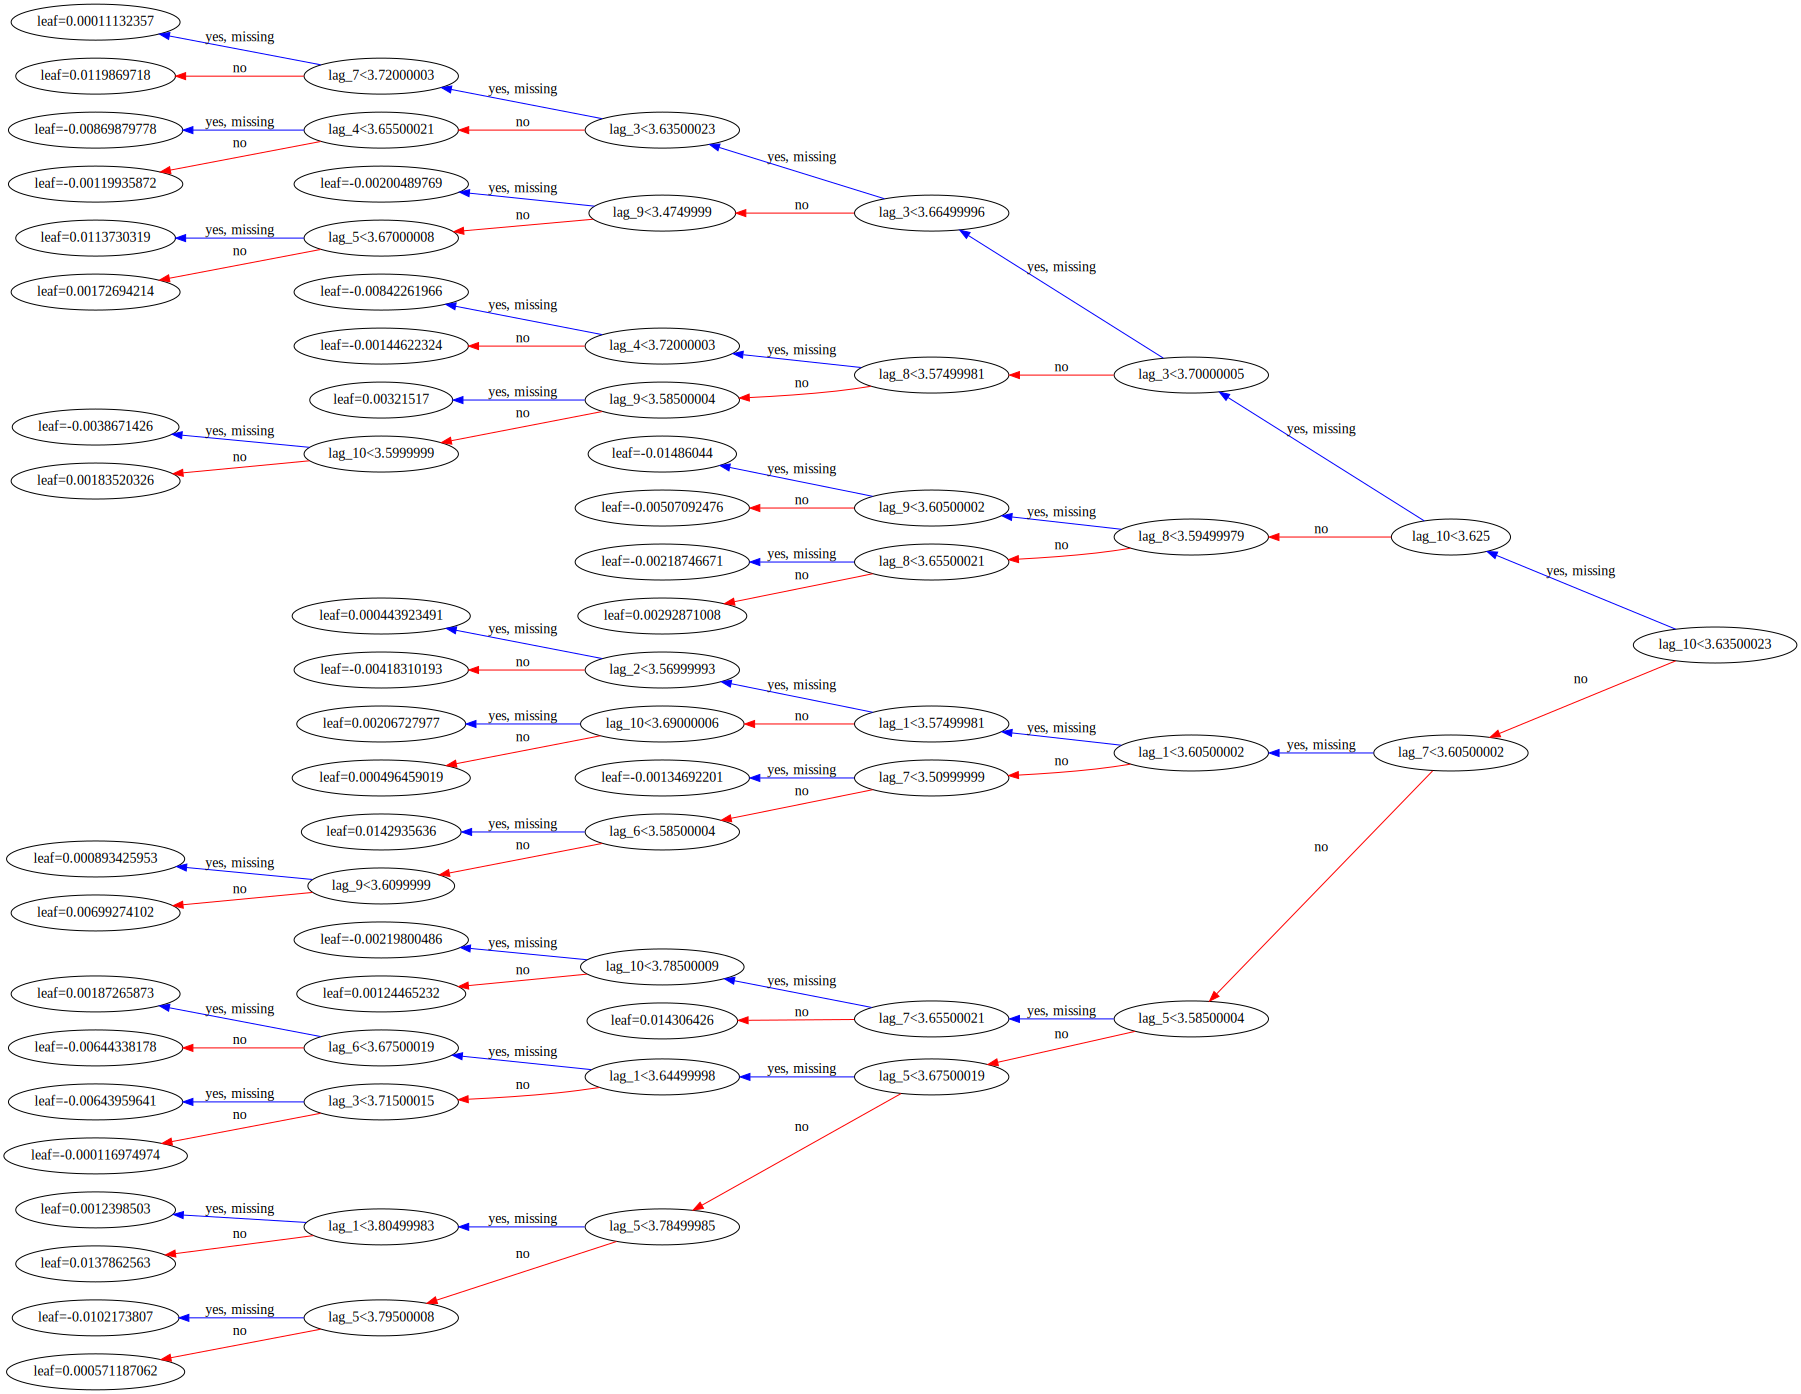

In [54]:
xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration,rankdir='RL')

In [55]:
mtm_xgb=trade_on_pred(y_ts_test,y_ts_test_pred,spread,test_mae*100)
mtm_xgb

Long   Short  Total  Trades Spread
Pos    68.0   -71.0   -3.0     139      2
MTM  8968.0 -8543.0  425.0     243

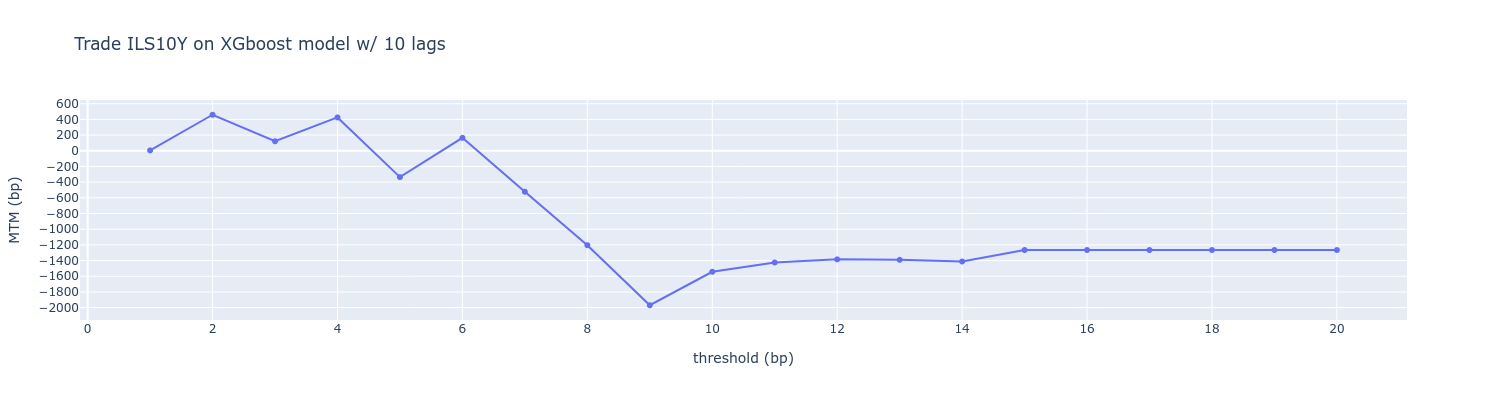

In [56]:
title=f'Trade ILS10Y on XGboost model w/ {n_lag} lags'
trade_simulation_plot(y_ts_test,y_ts_test_pred,spread,title).show()

In [57]:
# fit SVR model
svr_model = SVR(kernel = 'rbf', gamma='scale')
svr_model.fit(X_ts_train, y_ts_train)

SVR()

In [58]:
y_ts_train_pred = svr_model.predict(X_ts_train)
y_ts_test_pred  = svr_model.predict(X_ts_test)

train_mae = mean_absolute_error(y_ts_train, y_ts_train_pred)
test_mae  = mean_absolute_error(y_ts_test, y_ts_test_pred)

train_err_std = (y_ts_train - y_ts_train_pred).std()
test_err_std  = (y_ts_test  - y_ts_test_pred).std()

print(f'Train MAE: {train_mae:.3f} ({train_err_std:.3f}), Test MAE: {test_mae:.3f} ({test_err_std:.3f})')

Train MAE: 0.034 (0.045), Test MAE: 0.037 (0.045)


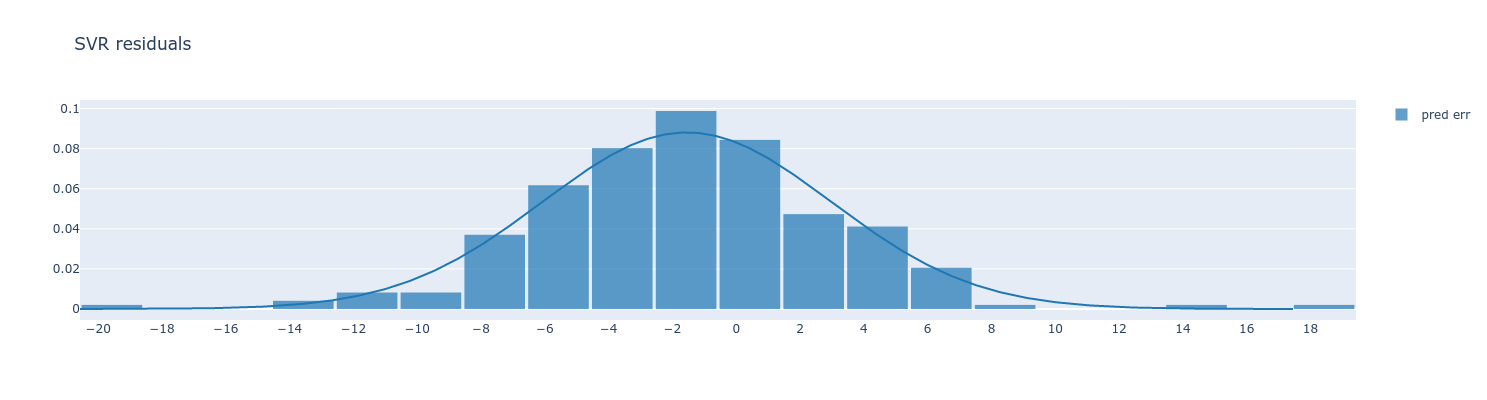

In [59]:
title='SVR residuals'
residuals_dist_plot(y_ts_test,y_ts_test_pred,'probability density','normal',title)

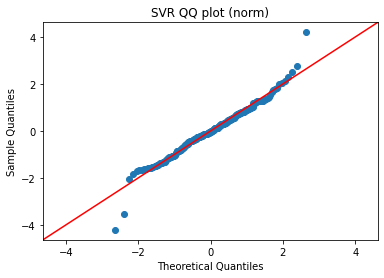

In [60]:
# QQ plot to check if residuals are normal distributed
residuals_QQ_plot(y_ts_test,y_ts_test_pred,'SVR QQ plot (norm)').show()

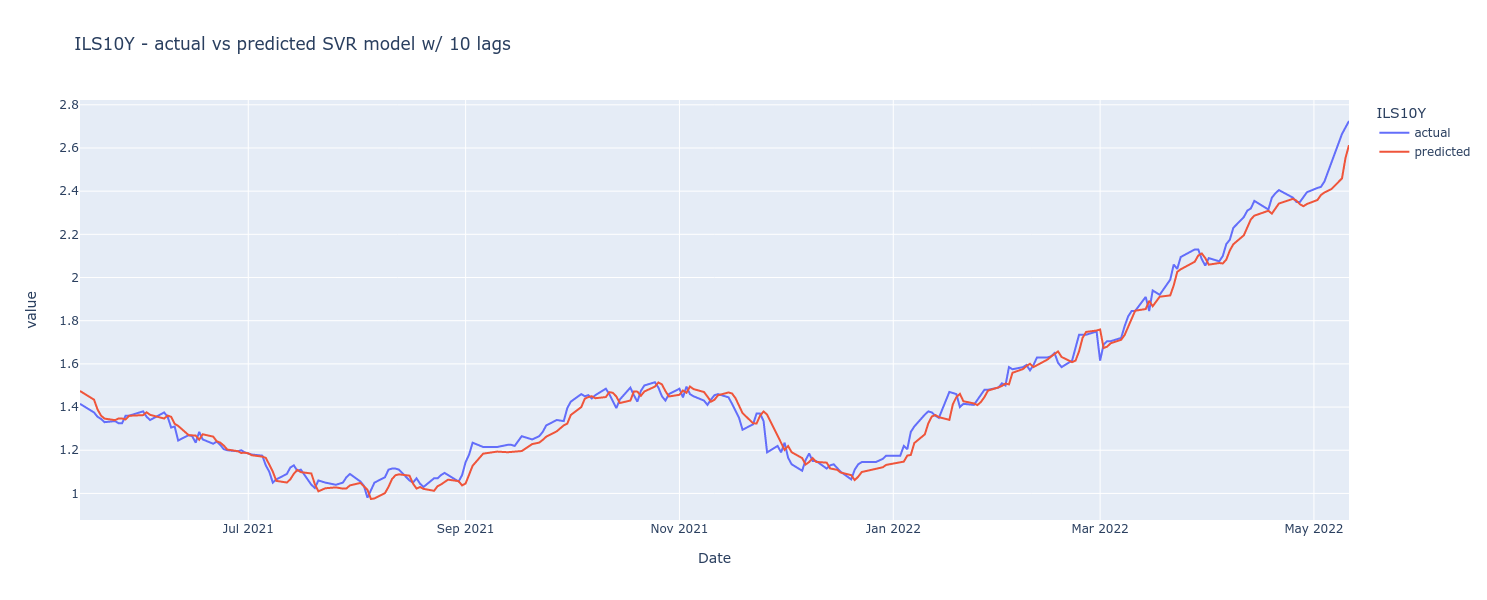

In [61]:
# test set - actual vs predicted plot
title=f'{target} - actual vs predicted SVR model w/ {n_lag} lags'
test_predicted_plot(y_ts_test.values, y_ts_test_pred, y_ts_test.index, title,target).show()

In [62]:
mtm_svr=trade_on_pred(y_ts_test,y_ts_test_pred,spread,test_mae*100)
mtm_svr

Long    Short   Total  Trades Spread
Pos    52.0    -89.0   -37.0     141      2
MTM  6894.0 -11614.5 -4720.5     243

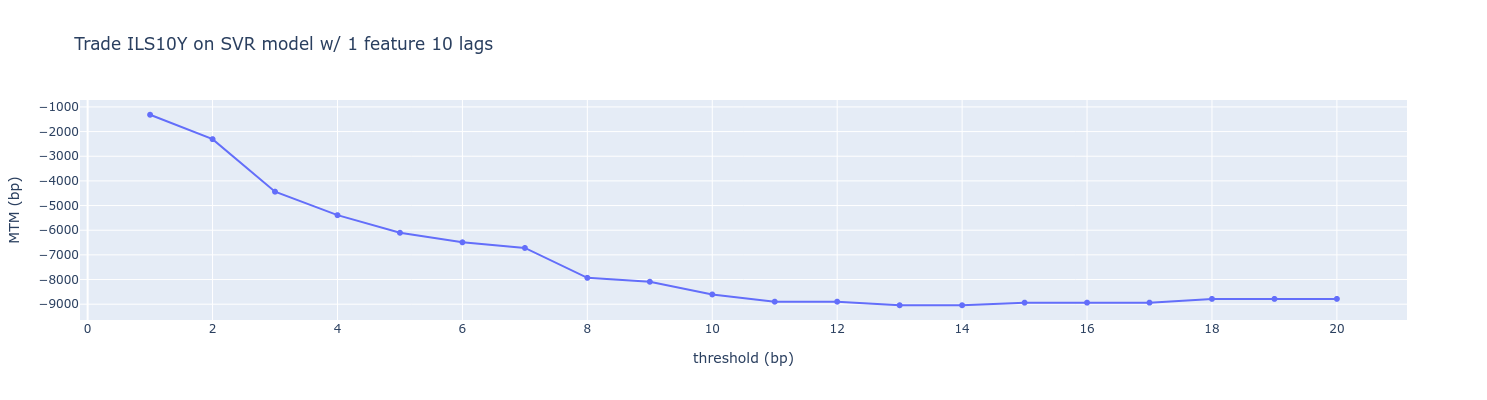

In [63]:
title=f'Trade ILS10Y on SVR model w/ {n_features} feature {n_lag} lags'
trade_simulation_plot(y_ts_test,y_ts_test_pred,spread,title).show()

#### Trading resulsts
* Although both models (XGBoost & SVR) gain low MAE on the test set, they eventually lose money w/o threshold
* Low MAE/MSE does not guarantee profit when trading on the prediction
* To gain profit we need higher prediction "error" on the "right side" of the market and lower prediction "error" on the "wrong side"

### Recurrent Neural Networks (RNN & LSTM)

* Recurrent Neural Networks are The Preferred Neural Network for sequences of Time-Series Data
* Classic RNNs can keep track of arbitrary long-term dependencies in the input sequences.
* The problem with vanilla RNNs is computational in nature: when training a vanilla RNN using back-propagation, the long-term gradients which are back-propagated can "vanish" (they can tend to zero) or "explode" (they can tend to infinity), because of the computations involved in the process, which use finite-precision numbers. 
* RNNs using LSTM units partially solve the vanishing gradient problem, because LSTM units allow gradients to also flow unchanged. 
* LSTM networks can still suffer from the exploding gradient problem.

<b>RNN network</b>

![RNN_Fig1](./img/RNN_Fig1.png)

<b>LSTM unit</b>
![LSTM_Fig1](./img/LSTM_Fig1.png)





#### Build and fit LTSM network

* Predict on 1 feature as input  - 10 lags of ILS10Y
* Predict on 13 features as input  - 10 lags of the all of the ILS curve (IRS 1Y-20Y) 
* Predict on 28 features as input - 10 lags of the all of the ILS + USD curves (ILS 1Y-20Y, USD 1Y-30Y) 

In order to get a better fit and convergence of the LSTM model its recommended to add normalize layer, which scale each feature w/ mean=0 and std=1


##### LSTM with 1 feature

In [64]:
# early stopping
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [ ]:
# define and fit the model
model, history=fit_LSTM_type2(
    X_train,y_train,X_test,y_test,n_lag,n_features,
    n_neurons=8,
    batch_size=3,
    n_epochs=1000,
    learning_rate=0.0001,
    verbose=1,
    callbacks=early_stopping_monitor
)

In [66]:
# model.save('./models/model_ILS10Y_1fN_3bp')
model = keras.models.load_model('./tf_models/model_ILS10Y_1f')
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 10, 1)]           0         
                                                                 
 normalize_layer (Normalizat  (None, 10, 1)            3         
 ion)                                                            
                                                                 
 first_layer (LSTM)          (None, 8)                 320       
                                                                 
 output_layer (Dense)        (None, 1)                 9         
                                                                 
Total params: 332
Trainable params: 329
Non-trainable params: 3
_________________________________________________________________


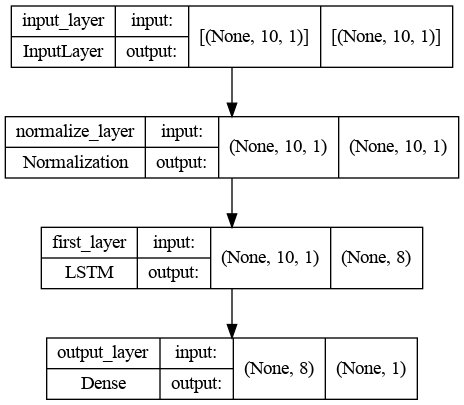

In [67]:
keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

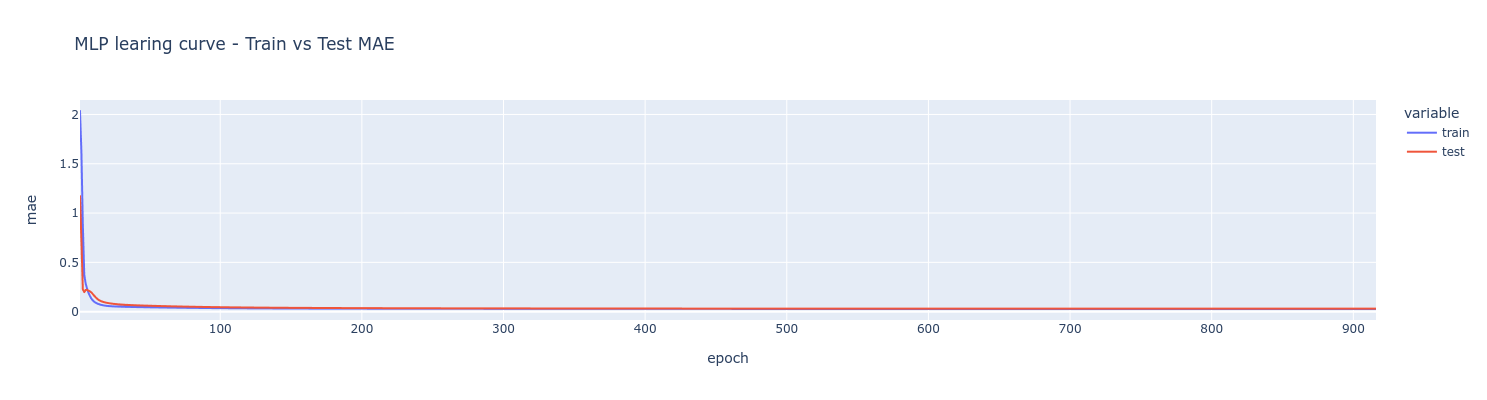

In [427]:
# plot mlp learnig curve
title='MLP learing curve - Train vs Test MAE'
mlp_learnig_curve_plot(history,title).show()

In [68]:
# evaluate the model
train_mae, test_mae = evaluate_model(model, X_train, y_train, X_test, y_test, verbose=0)
print(f'Train MAE: {train_mae:.3f}, Test MAE: {test_mae:.3f}')

Train MAE: 0.031, Test MAE: 0.030


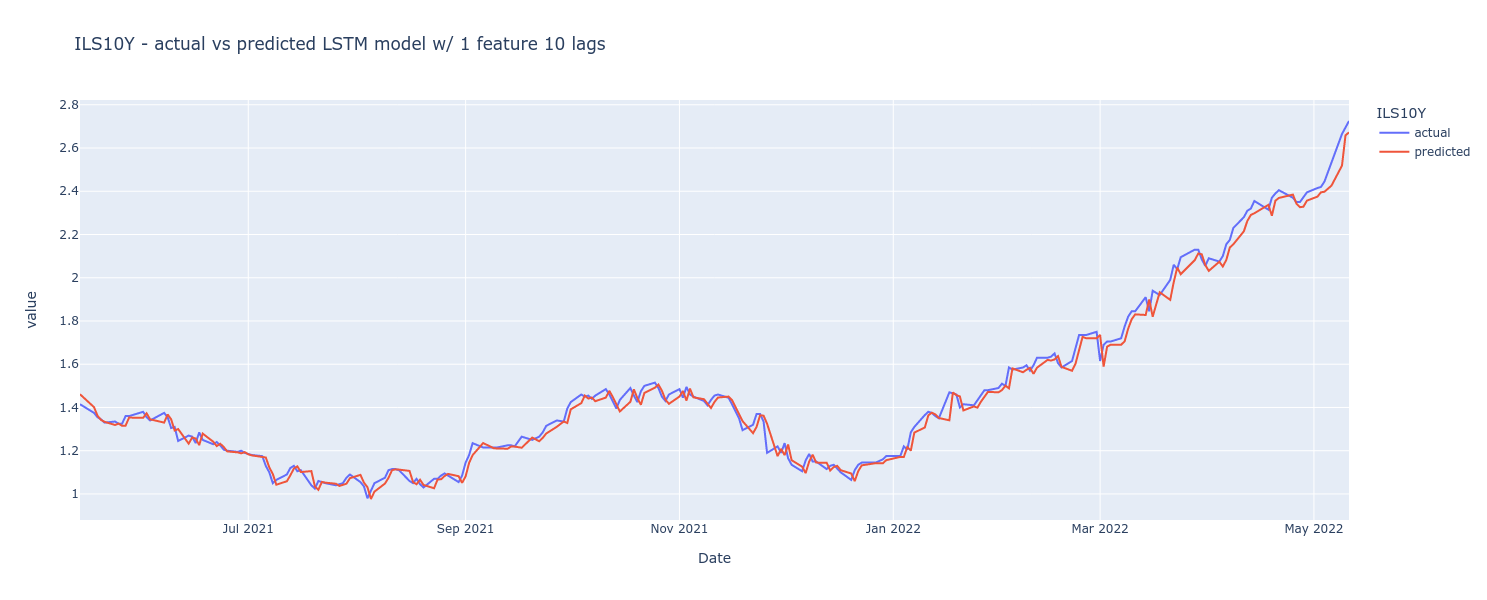

In [69]:
# test set - actual vs predicted plot
y_pred = model.predict(X_test)
title=f'{target} - actual vs predicted LSTM model w/ {n_features} feature {n_lag} lags'
test_predicted_plot(y_test, y_pred, test.index[n_lag:], title,target).show()

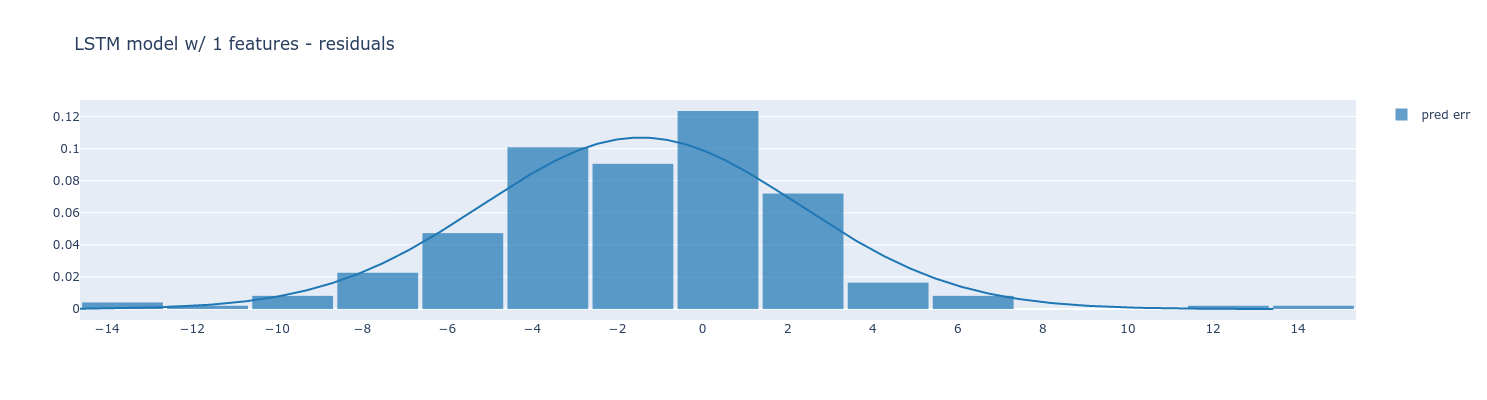

In [70]:
title=f'LSTM model w/ {n_features} features - residuals'
residuals_dist_plot(y_test,y_pred.reshape(-1),'probability density','normal',title)

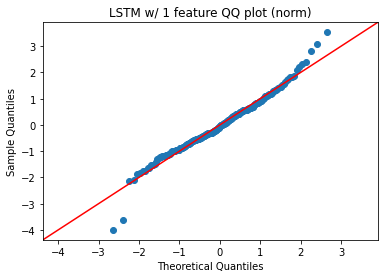

In [71]:
# QQ plot to check if residuals are normal distributed
residuals_QQ_plot(y_test,y_pred.reshape(-1),'LSTM w/ 1 feature QQ plot (norm)').show()

In [72]:
mtm_nn_1=trade_on_pred(y_test,y_pred,spread,test_mae*100)
mtm_nn_1

Long    Short   Total  Trades Spread
Pos    69.0    -79.0   -10.0     148      2
MTM  9304.0 -10504.5 -1200.5     243

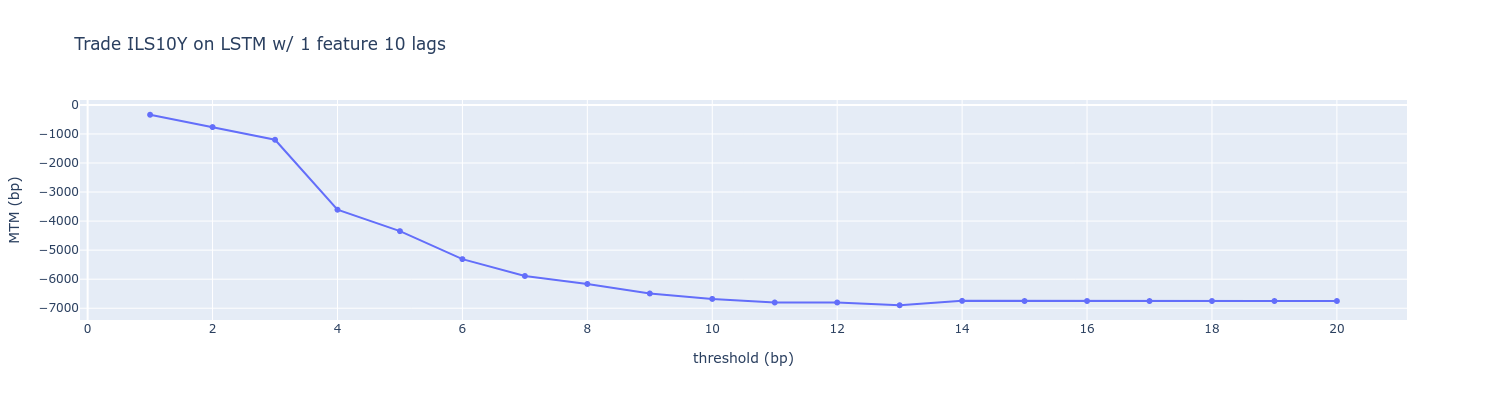

In [73]:
title=f'Trade ILS10Y on LSTM w/ {n_features} feature {n_lag} lags'
trade_simulation_plot(y_test,y_pred,spread,title).show()

In [74]:
# pred on last n_lag days for 1 day in the future
model.predict(test.tail(n_lag).values.reshape(1,n_lag,n_features))

array([[2.7057035]], dtype=float32)

* Despite the low predict MAE (3bp) and the good fit on the test set , the trading simulation shows a loss on evrey threshold

##### LSTM with 13 features - ILS swap curve 1Y-20Y

In [75]:
n_lag = 10
n_features = 13

In [76]:
ts3=ts_ILS
ts3

ILS1Y  ILS2Y  ILS3Y  ILS4Y  ILS5Y  ILS6Y  ILS7Y  ILS8Y  ILS9Y  \
Date                                                                        
2011-12-19  2.300  2.410  2.600  2.860  3.160  3.460  3.740  3.930  4.100   
2011-12-20  2.300  2.420  2.610  2.870  3.170  3.470  3.750  3.940  4.110   
2011-12-21  2.310  2.430  2.620  2.880  3.180  3.480  3.750  3.940  4.110   
2011-12-22  2.310  2.440  2.620  2.870  3.160  3.460  3.730  3.920  4.080   
2011-12-23  2.310  2.440  2.620  2.870  3.160  3.460  3.730  3.920  4.080   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-05-04  1.435  1.950  2.120  2.175  2.220  2.265  2.315  2.370  2.420   
2022-05-06  1.485  2.025  2.195  2.255  2.305  2.355  2.405  2.455  2.505   
2022-05-09  1.555  2.105  2.280  2.345  2.405  2.465  2.525  2.585  2.640   
2022-05-10  1.585  2.140  2.310  2.375  2.435  2.495  2.555  2.615  2.670   
2022-05-11  1.635  2.195  2.360  2.425  2.485  2.540  2.590  2.645  2.700   

            ILS10Y  ILS12Y  ILS15Y  ILS20Y  
Date                                        
2011-12-19   4.230   4.440   4.680   4.800  
2011-12-20   4.240   4.450   4.690   4.810  
2011-12-21   4.240   4.450   4.690   4.810  
2011-12-22   4.210   4.420   4.660   4.780  
2011-12-23   4.210   4.420   4.660   4.780  
...            ...     ...     ...     ...  
2022-05-04   2.445   2.485   2.560   2.710  
2022-05-06   2.530   2.570   2.645   2.795  
2022-05-09   2.665   2.705   2.780   2.930  
2022-05-10   2.695   2.735   2.810   2.960  
2022-05-11   2.725   2.760   2.830   2.980  

[2528 rows x 13 columns]

In [77]:
train,test = ts_train_test_split(ts3,0.9)
print(len(train), len(test))

2275 253


In [78]:
ts3.isna().sum()

ILS1Y     0
ILS2Y     0
ILS3Y     0
ILS4Y     0
ILS5Y     0
ILS6Y     0
ILS7Y     0
ILS8Y     0
ILS9Y     0
ILS10Y    0
ILS12Y    0
ILS15Y    0
ILS20Y    0
dtype: int64

In [322]:
# reshape to [samples, n_lags, n_features]
X_train, y_train = create_dataset(train, train[target], n_lag)
X_test, y_test = create_dataset(test, test[target], n_lag)

print(f'X_train shape:{X_train.shape}  y_train shape:{y_train.shape}')
print(f'X_test  shape:{X_test.shape}   y_test  shape:{y_test.shape}')

X_train shape:(2258, 10, 28)  y_train shape:(2258,)
X_test  shape:(242, 10, 28)   y_test  shape:(242,)


In [126]:
# define and fit the model 
model, history=fit_LSTM_type2(
    X_train,y_train,X_test,y_test,n_lag,n_features,
    n_neurons=32,
    batch_size=3,
    n_epochs=1000,
    learning_rate=0.0001,
    verbose=1,
    callbacks=early_stopping_monitor
)

Epoch 1/1000
755/755 [==============================] - 14s 13ms/step - loss: 4.3686 - mae: 1.7564 - val_loss: 0.7075 - val_mae: 0.6688
Epoch 2/1000
755/755 [==============================] - 8s 11ms/step - loss: 0.4621 - mae: 0.3853 - val_loss: 0.3256 - val_mae: 0.4324
Epoch 3/1000
755/755 [==============================] - 9s 11ms/step - loss: 0.0381 - mae: 0.1276 - val_loss: 0.2557 - val_mae: 0.3273
Epoch 4/1000
755/755 [==============================] - 9s 12ms/step - loss: 0.0267 - mae: 0.1022 - val_loss: 0.2013 - val_mae: 0.2479
Epoch 5/1000
755/755 [==============================] - 8s 11ms/step - loss: 0.0191 - mae: 0.0886 - val_loss: 0.1574 - val_mae: 0.2211
Epoch 6/1000
755/755 [==============================] - 8s 11ms/step - loss: 0.0141 - mae: 0.0785 - val_loss: 0.1196 - val_mae: 0.2068
Epoch 7/1000
755/755 [==============================] - 8s 11ms/step - loss: 0.0109 - mae: 0.0702 - val_loss: 0.0881 - val_mae: 0.1903
Epoch 8/1000
755/755 [==============================] 

In [80]:
model = keras.models.load_model('./tf_models/model_ILS10Y_13f')
# model.save('./tf_models/model_ILS10Y_13f_4bp')
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 10, 13)]          0         
                                                                 
 normalize_layer (Normalizat  (None, 10, 13)           27        
 ion)                                                            
                                                                 
 first_layer (LSTM)          (None, 32)                5888      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 5,948
Trainable params: 5,921
Non-trainable params: 27
_________________________________________________________________


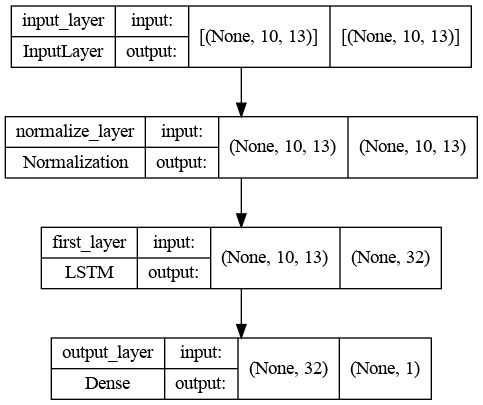

In [81]:
keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

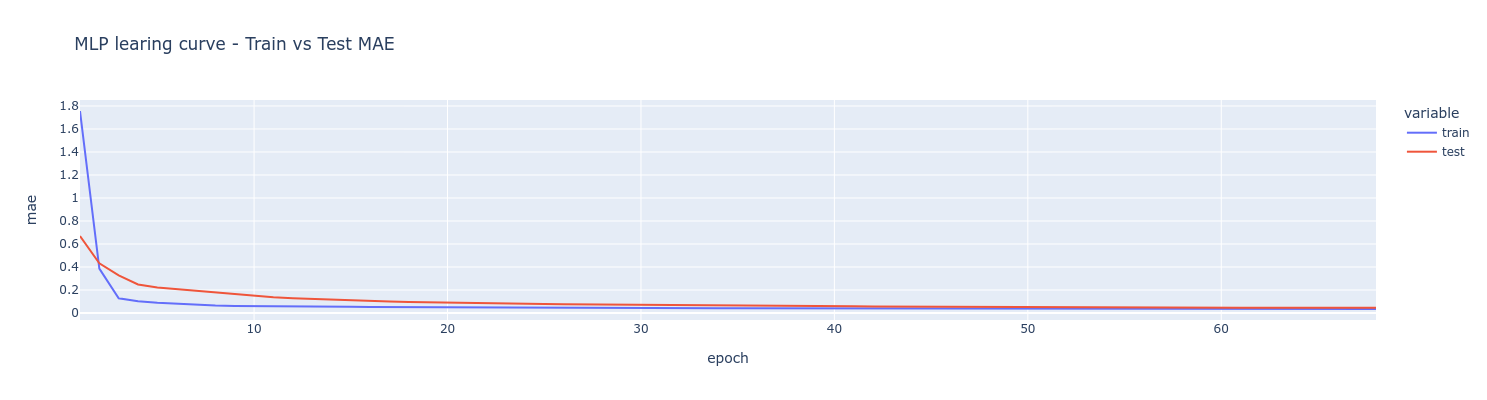

In [129]:
# plot mlp learnig curve
title='MLP learing curve - Train vs Test MAE'
mlp_learnig_curve_plot(history,title).show()

In [82]:
# evaluate the model
train_mae = model.evaluate(X_train, y_train, verbose=0)[1]
test_mae = model.evaluate(X_test, y_test, verbose=0)[1]
print(f'Train MAE: {train_mae:.3f}, Test MAE: {test_mae:.3f}')

Train MAE: 0.048, Test MAE: 0.045


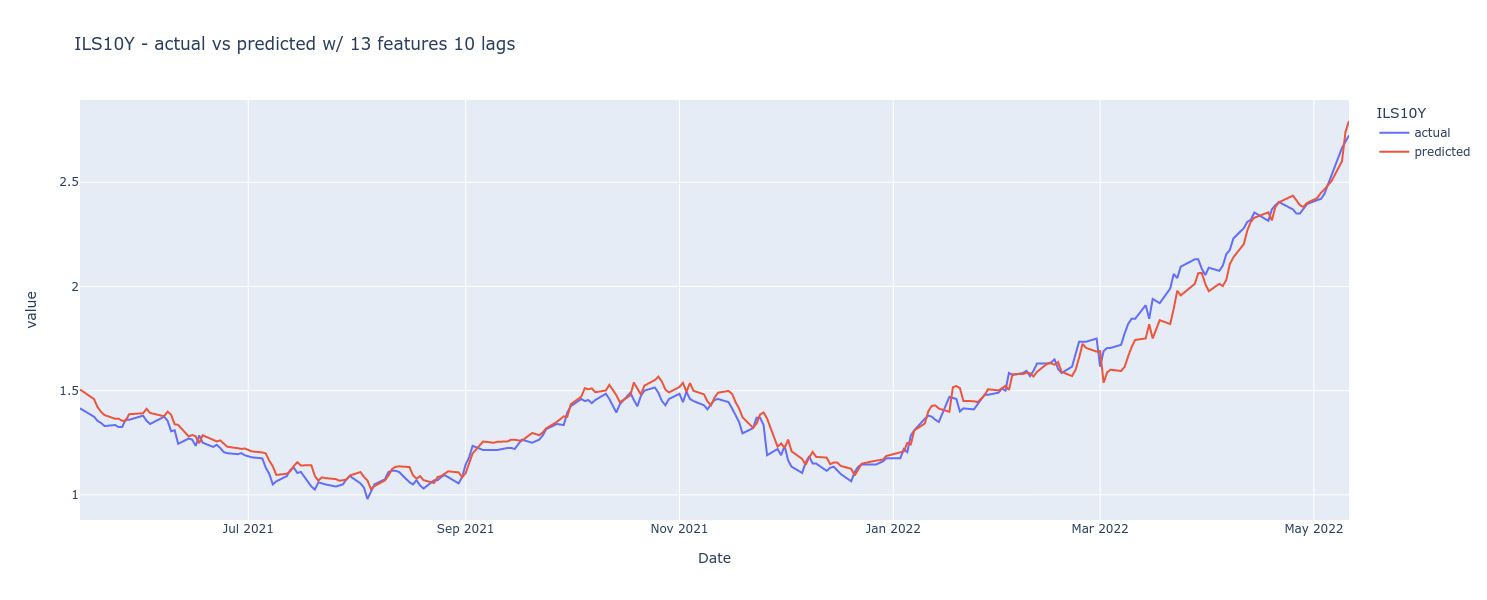

In [83]:
# test set - actual vs predicted plot
y_pred = model.predict(X_test)
title=f'{target} - actual vs predicted w/ {n_features} features {n_lag} lags'
test_predicted_plot(y_test, y_pred, test.index[n_lag:], title,target).show()

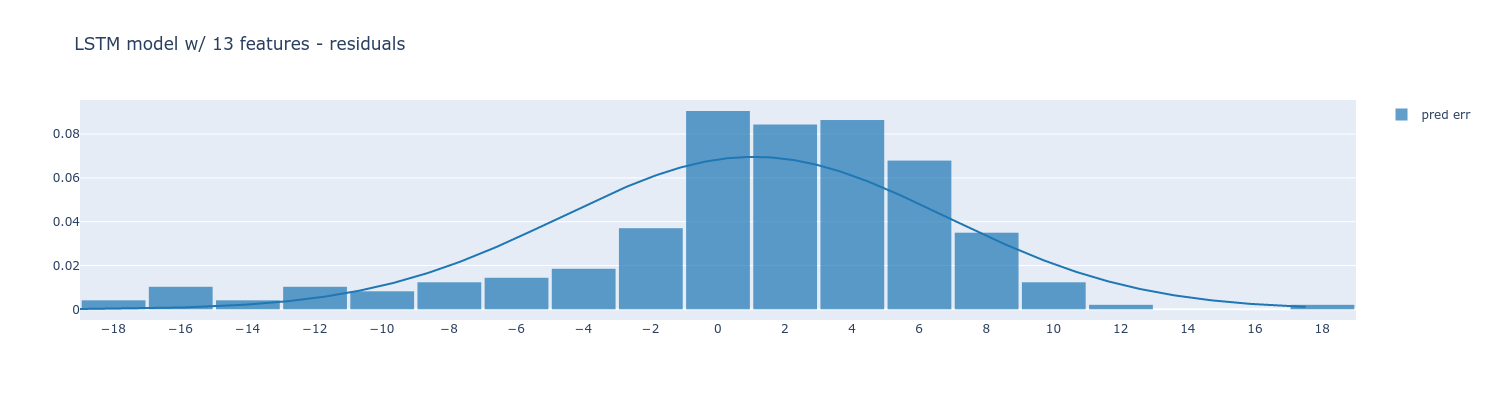

In [84]:
title=f'LSTM model w/ {n_features} features - residuals'
residuals_dist_plot(y_test,y_pred.reshape(-1),'probability density','normal',title)

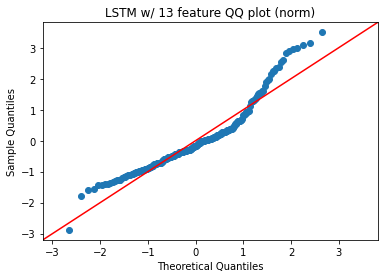

In [85]:
# QQ plot to check if residuals are normal distributed
residuals_QQ_plot(y_test,y_pred.reshape(-1),'LSTM w/ 13 feature QQ plot (norm)').show()

In [86]:
mtm_nn_2=trade_on_pred(y_test,y_pred,spread,test_mae*100)
mtm_nn_2

Long   Short   Total  Trades Spread
Pos    103.0   -45.0    58.0     148      2
MTM  14004.0 -5445.0  8559.0     243

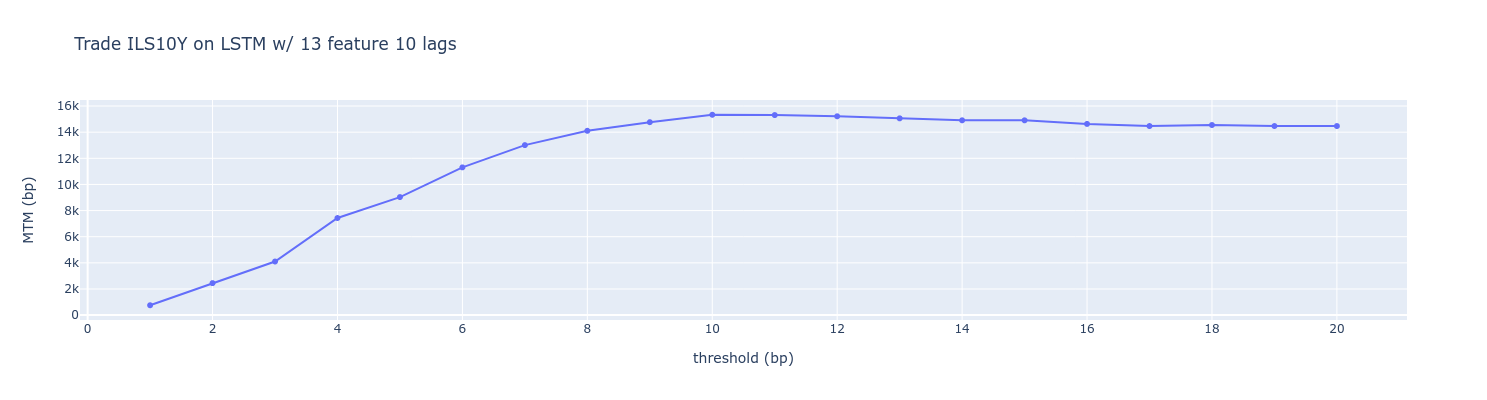

In [87]:
title=f'Trade ILS10Y on LSTM w/ {n_features} feature {n_lag} lags'
trade_simulation_plot(y_test,y_pred,spread,title).show()

In [88]:
# pred on last n_lag days for 1 day in the future
model.predict(test.tail(n_lag).values.reshape(1,n_lag,n_features))

array([[2.8469183]], dtype=float32)

Summary
* when using all the ILS curve tenors as an input (10 lags) we get test MAE of 4.5bp and positive P/L up to 15K bp!!!
* The model seems to be using the additional information that comes from the additional features.

##### LSTM with 28 featurs - ILS+USD swap curves

In [89]:
df_USDIRS_curve = pd.read_csv('./data/USDIRS_AM3L_data.csv',parse_dates=['Date'])

In [90]:
cols=df_USDIRS_curve.columns
cols

Index(['Date', 'USD1Y', 'USD2Y', 'USD3Y', 'USD4Y', 'USD5Y', 'USD6Y', 'USD7Y',
       'USD8Y', 'USD9Y', 'USD10Y', 'USD12Y', 'USD15Y', 'USD20Y', 'USD25Y',
       'USD30Y', 'USD40Y', 'USD50Y'],
      dtype='object')

In [91]:
df_USDIRS_curve['Date'].duplicated().sum()

0

In [92]:
cols_to_drop=['USD40Y','USD50Y']
cols = [col for col in cols if col not in cols_to_drop]

In [93]:
ts_USD=df_USDIRS_curve[cols].set_index('Date').sort_index(ascending=True)
start_date ,end_date = '2011-12-19','2022-05-11'
ts_USD=ts_USD[start_date:end_date]

In [94]:
ts_USD.isna().sum()

USD1Y     0
USD2Y     0
USD3Y     0
USD4Y     0
USD5Y     0
USD6Y     0
USD7Y     0
USD8Y     0
USD9Y     0
USD10Y    0
USD12Y    0
USD15Y    0
USD20Y    0
USD25Y    0
USD30Y    0
dtype: int64

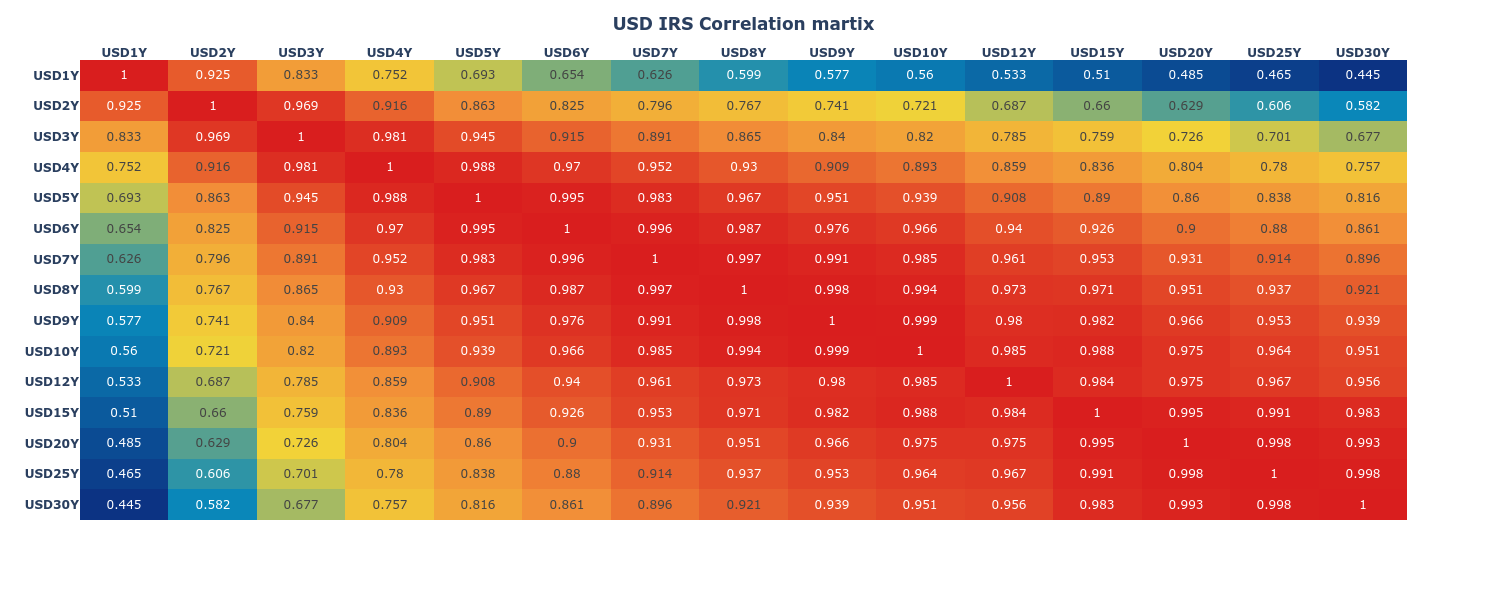

In [95]:
correlation_matrix_plot(ts_USD.diff(axis=0).corr(),"<b>USD IRS Correlation martix</b>").show()

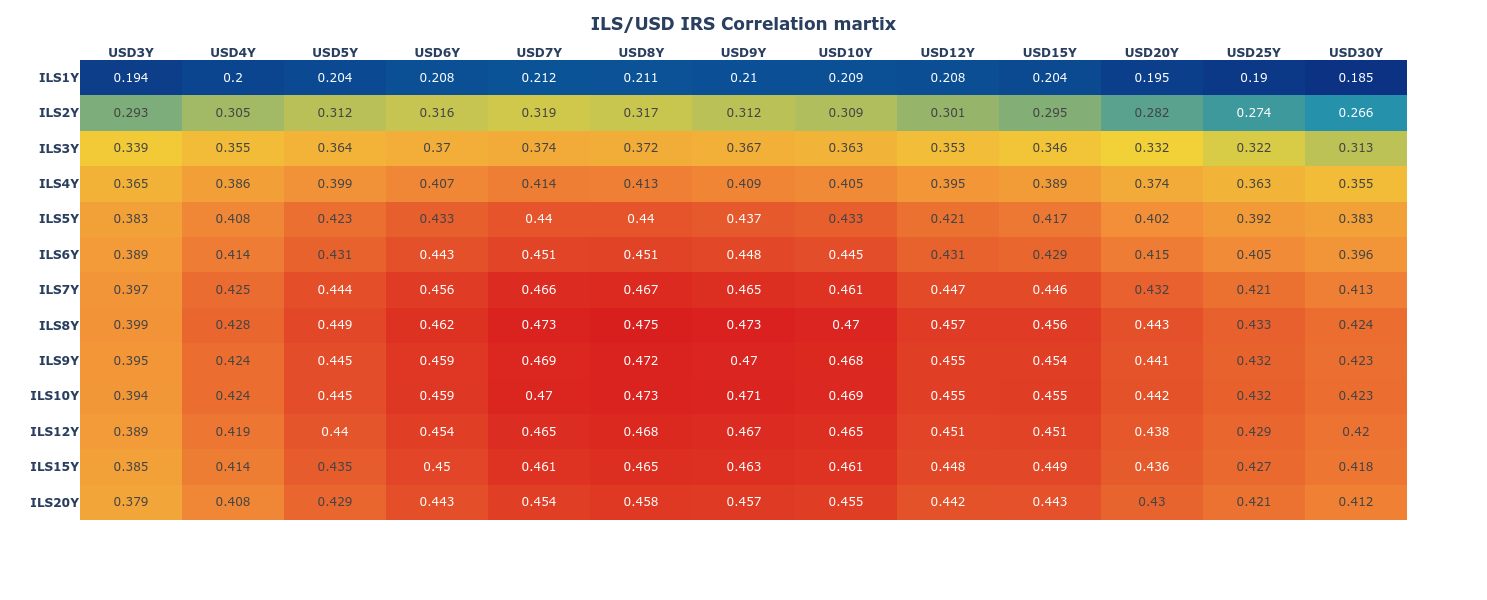

In [96]:
correlation_matrix_plot(ts_ILS.merge(ts_USD,on='Date',how='left').dropna(how='any').diff(axis=0).corr().iloc[:13,-13:],"<b>ILS/USD IRS Correlation martix</b>").show()

In [97]:
n_lag = 10
n_features = 28

In [323]:
# merge the USD time-series on the ILS dates
ts4=ts_ILS.merge(ts_USD,on='Date',how='left').dropna(how='any')

In [99]:
ts4.index.duplicated().sum()

0

In [100]:
train,test = ts_train_test_split(ts4,0.9)
print(len(train), len(test))

2268 252


In [324]:
# reshape to [samples, n_lag, n_features]
X_train, y_train = create_dataset(train, train[target], n_lag)
X_test, y_test = create_dataset(test, test[target], n_lag)

print(f'X_train shape:{X_train.shape}  y_train shape:{y_train.shape}')
print(f'X_test  shape:{X_test.shape}   y_test  shape:{y_test.shape}')

X_train shape:(2258, 10, 28)  y_train shape:(2258,)
X_test  shape:(242, 10, 28)   y_test  shape:(242,)


In [251]:
# define and fit the model 
model, history=fit_LSTM_type3(
    X_train,y_train,X_test,y_test,n_lag,n_features,
    n1_neurons=64,
    n2_neurons=64,
    batch_size=3,
    n_epochs=1000,
    learning_rate=0.0001,
    verbose=1,
    callbacks=early_stopping_monitor
)

Epoch 1/1000
753/753 [==============================] - 25s 24ms/step - loss: 0.9791 - mae: 0.6122 - val_loss: 0.9984 - val_mae: 0.9036
Epoch 2/1000
753/753 [==============================] - 16s 21ms/step - loss: 0.0557 - mae: 0.1767 - val_loss: 0.5997 - val_mae: 0.6188
Epoch 3/1000
753/753 [==============================] - 16s 21ms/step - loss: 0.0715 - mae: 0.1757 - val_loss: 0.4341 - val_mae: 0.5250
Epoch 4/1000
753/753 [==============================] - 16s 21ms/step - loss: 0.0425 - mae: 0.1447 - val_loss: 0.3059 - val_mae: 0.4333
Epoch 5/1000
753/753 [==============================] - 16s 22ms/step - loss: 0.0266 - mae: 0.1214 - val_loss: 0.2326 - val_mae: 0.3797
Epoch 6/1000
753/753 [==============================] - 17s 22ms/step - loss: 0.0194 - mae: 0.1061 - val_loss: 0.1857 - val_mae: 0.3356
Epoch 7/1000
753/753 [==============================] - 16s 21ms/step - loss: 0.0162 - mae: 0.0965 - val_loss: 0.1608 - val_mae: 0.3136
Epoch 8/1000
753/753 [==========================

In [313]:
# model.save('./tf_models/model_ILS10Y_28f')
model = keras.models.load_model('./tf_models/model_ILS10Y_28f')
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 10, 28)]          0         
                                                                 
 normalize_layer (Normalizat  (None, 10, 28)           57        
 ion)                                                            
                                                                 
 first_layer (LSTM)          (None, 10, 64)            23808     
                                                                 
 second_layer (LSTM)         (None, 64)                33024     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 56,954
Trainable params: 56,897
Non-trainable params: 57
_____________________________________________________

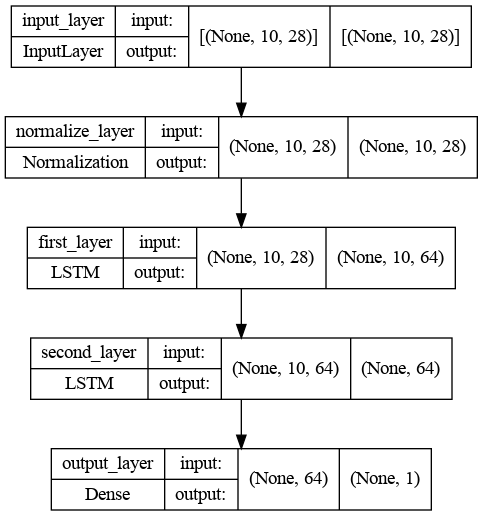

In [314]:
keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

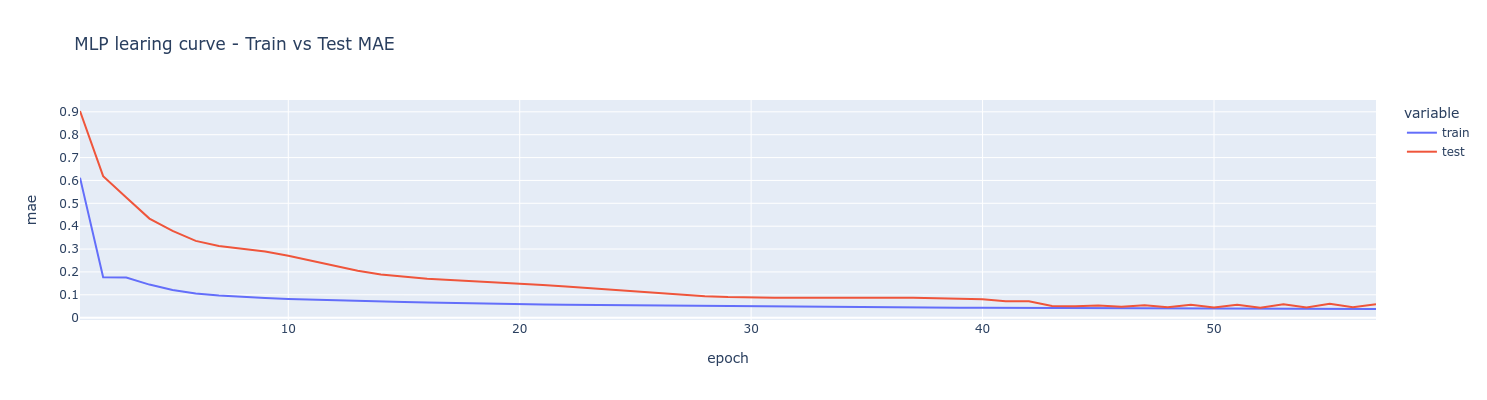

In [289]:
# plot mlp learnig curve
title='MLP learing curve - Train vs Test MAE'
mlp_learnig_curve_plot(history,title).show()

In [315]:
# evaluate the model
train_mae = model.evaluate(X_train, y_train, verbose=0)[1]
test_mae = model.evaluate(X_test, y_test, verbose=0)[1]
print(f'Train MAE: {train_mae:.3f}, Test MAE: {test_mae:.3f}')

Train MAE: 0.077, Test MAE: 0.044


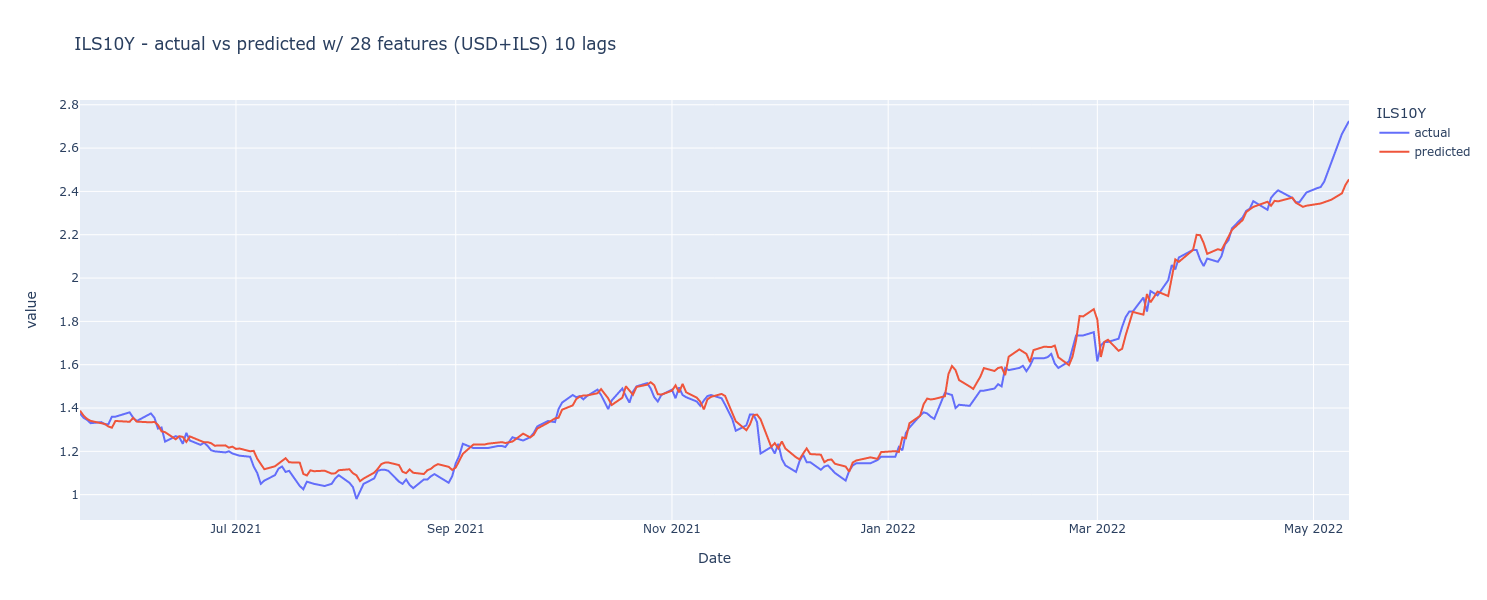

In [316]:
# test set - actual vs predicted plot
y_pred = model.predict(X_test)
title=f'{target} - actual vs predicted w/ {n_features} features (USD+ILS) {n_lag} lags'
test_predicted_plot(y_test, y_pred, test.index[n_lag:], title,target).show()

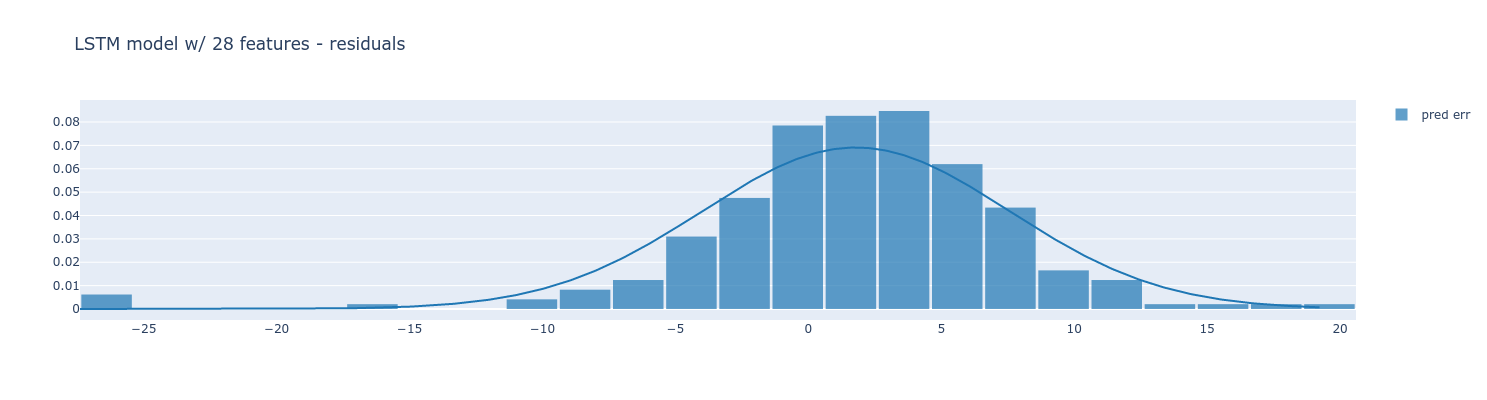

In [317]:
title=f'LSTM model w/ {n_features} features - residuals'
residuals_dist_plot(y_test,y_pred.reshape(-1),'probability density','normal',title)

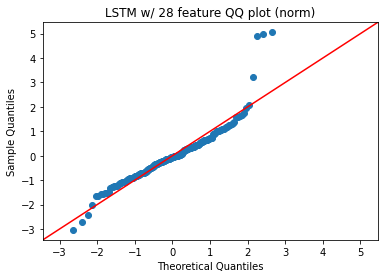

In [318]:
# QQ plot to check if residuals are normal distributed
residuals_QQ_plot(y_test,y_pred.reshape(-1),'LSTM w/ 28 feature QQ plot (norm)').show()

In [319]:
mtm_nn_3=trade_on_pred(y_test,y_pred,spread,test_mae*100)
mtm_nn_3

Long   Short   Total  Trades Spread
Pos     91.0   -57.0    34.0     148      2
MTM  12548.5 -6587.5  5961.0     242

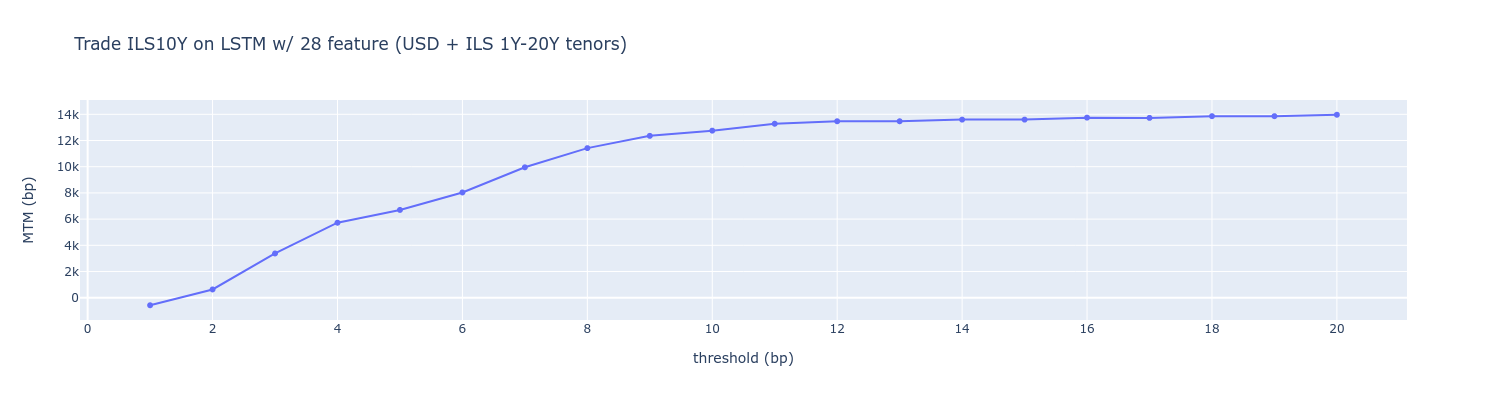

In [320]:
title=f'Trade ILS10Y on LSTM w/ 28 feature (USD + ILS 1Y-20Y tenors)'
trade_simulation_plot(y_test,y_pred,spread,title).show()

In [312]:
# pred on last n_lag days for 1 day in the future
model.predict(test.tail(n_lag).values.reshape(1,n_lag,n_features))

array([[2.484674]], dtype=float32)

* When adding the USD swap curve data as features to the features come from the ILS curve we get same MAE (4.5bp) on the test set
* Similar results on the trading simmulation
* Although there is no improvement in the P/L results of the trading simulation when adding the USD swap curve, it helps to establish the model's significance

### <b>Conclusions</b>
* For the ILS IRS10Y time series and from the aspect of MAE/MSE prediction, LSTM w/ 1 feature (MAE 3bp) performs better then the otther tested regressors like XGBoost (MAE 4bp) and SVR (3.7bp)
* When using only 1 feature all baseline methods (lag_1, SMA) and the other more complex regressors (LSTM, XGBoost, SVR) <b>lose money</b> when trading on the model next day prediction.
* Getting low prediction MAE/MSE on the test set does not guarantee profit when trading, mainly because of the lag nature of the prediction.
* LSTM get the advantage and <b>make money</b> on the trading simulation when using more feauters.